# Data preparation notebook

>this note book will be a starter file for the data preparation, data loading, data cleaning, data visulaization, feature engineering and
uploading train and test datasets to S3 to be used in the model training pipeline and to be used in the model deployment pipeline.

## Installing packages and importing libraries

In [2]:
pip install --upgrade pip

  Using cached pip-23.1.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install sagemaker ipywidgets --upgrade --quiet

ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [6]:
import boto3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from scipy import stats
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sagemaker
from sagemaker import image_uris

from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

In [7]:
import matplotlib.dates as mdates
from scipy import stats
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error
from sklearn.decomposition import PCA, IncrementalPCA

In [8]:
# Run this cell to import or install the Data Wrangler widget to show automatic visualization and generate code to fix data quality issues

try:
    import sagemaker_datawrangler
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler

# Display Pandas DataFrame to view the widget: df, display(df), df.sample()... 

## Loading data 

In [9]:
df=pd.read_csv('Fractionator.csv')

In [10]:
df.head()

             Time  AI_2020_OVERHEAD_C5'S_MOL  AI_2021_MIDDLE_C7'S_MOL  \
0  10/1/2009 8:14                    2.00000                  3.00000   
1  10/1/2009 8:15                    2.00360                  3.00954   
2  10/1/2009 8:16                    2.00870                  2.99518   
3  10/1/2009 8:17                    2.00385                  3.01356   
4  10/1/2009 8:18                    1.99852                  3.02963   

   AI_2022_BOTTOM_C3'S_MOL  FIC_2100_PV_FEED_FURNACE_FUEL_SCFH  \
0                  4.00000                             8.50000   
1                  3.99831                             8.50735   
2                  3.97746                             8.50977   
3                  3.97262                             8.50838   
4                  3.98841                             8.50365   

   FIC-2101_PV_TOP_PRODUCT_MBBL/D  FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D  \
0                         2.10000                            1.70000   
1                   

In [11]:
df.columns

Index(['Time', 'AI_2020_OVERHEAD_C5'S_MOL', 'AI_2021_MIDDLE_C7'S_MOL',
       'AI_2022_BOTTOM_C3'S_MOL', 'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH',
       'FIC-2101_PV_TOP_PRODUCT_MBBL/D', 'FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D',
       'FI-2005_PV_FEED_FLOW_MBBL/D', 'FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC-2001_OP_TOP_REFLUX_OUTPUT_%',
       'FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D',
       'FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%',
       'FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D',
       'FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D',
       'FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%', 'FIC_2004_PV_TOP_REFLUX_MBBL/D',
       'QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H',
       'TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF'],
      dtype='object')

In [12]:
from datetime import date
df['Time']=pd.to_datetime(df['Time'])

In [13]:
original_data=df.copy()

In [27]:
#splitting columns into groups according to data influence on the system
manipulated_variables=["AI_2020_OVERHEAD_C5'S_MOL", "AI_2021_MIDDLE_C7'S_MOL",
       "AI_2022_BOTTOM_C3'S_MOL"]
controlled_variables=[
       'FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC-2001_OP_TOP_REFLUX_OUTPUT_%',
       'FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D',
       'FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%',
       'FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D',
       'FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%', 
       'TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF']
reponse_variables=['FIC_2100_PV_FEED_FURNACE_FUEL_SCFH',
       'FIC-2101_PV_TOP_PRODUCT_MBBL/D', 'FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D',
       'FI-2005_PV_FEED_FLOW_MBBL/D',
       'FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D',
       'FIC_2004_PV_TOP_REFLUX_MBBL/D',
       'QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H',]

### plotting the data

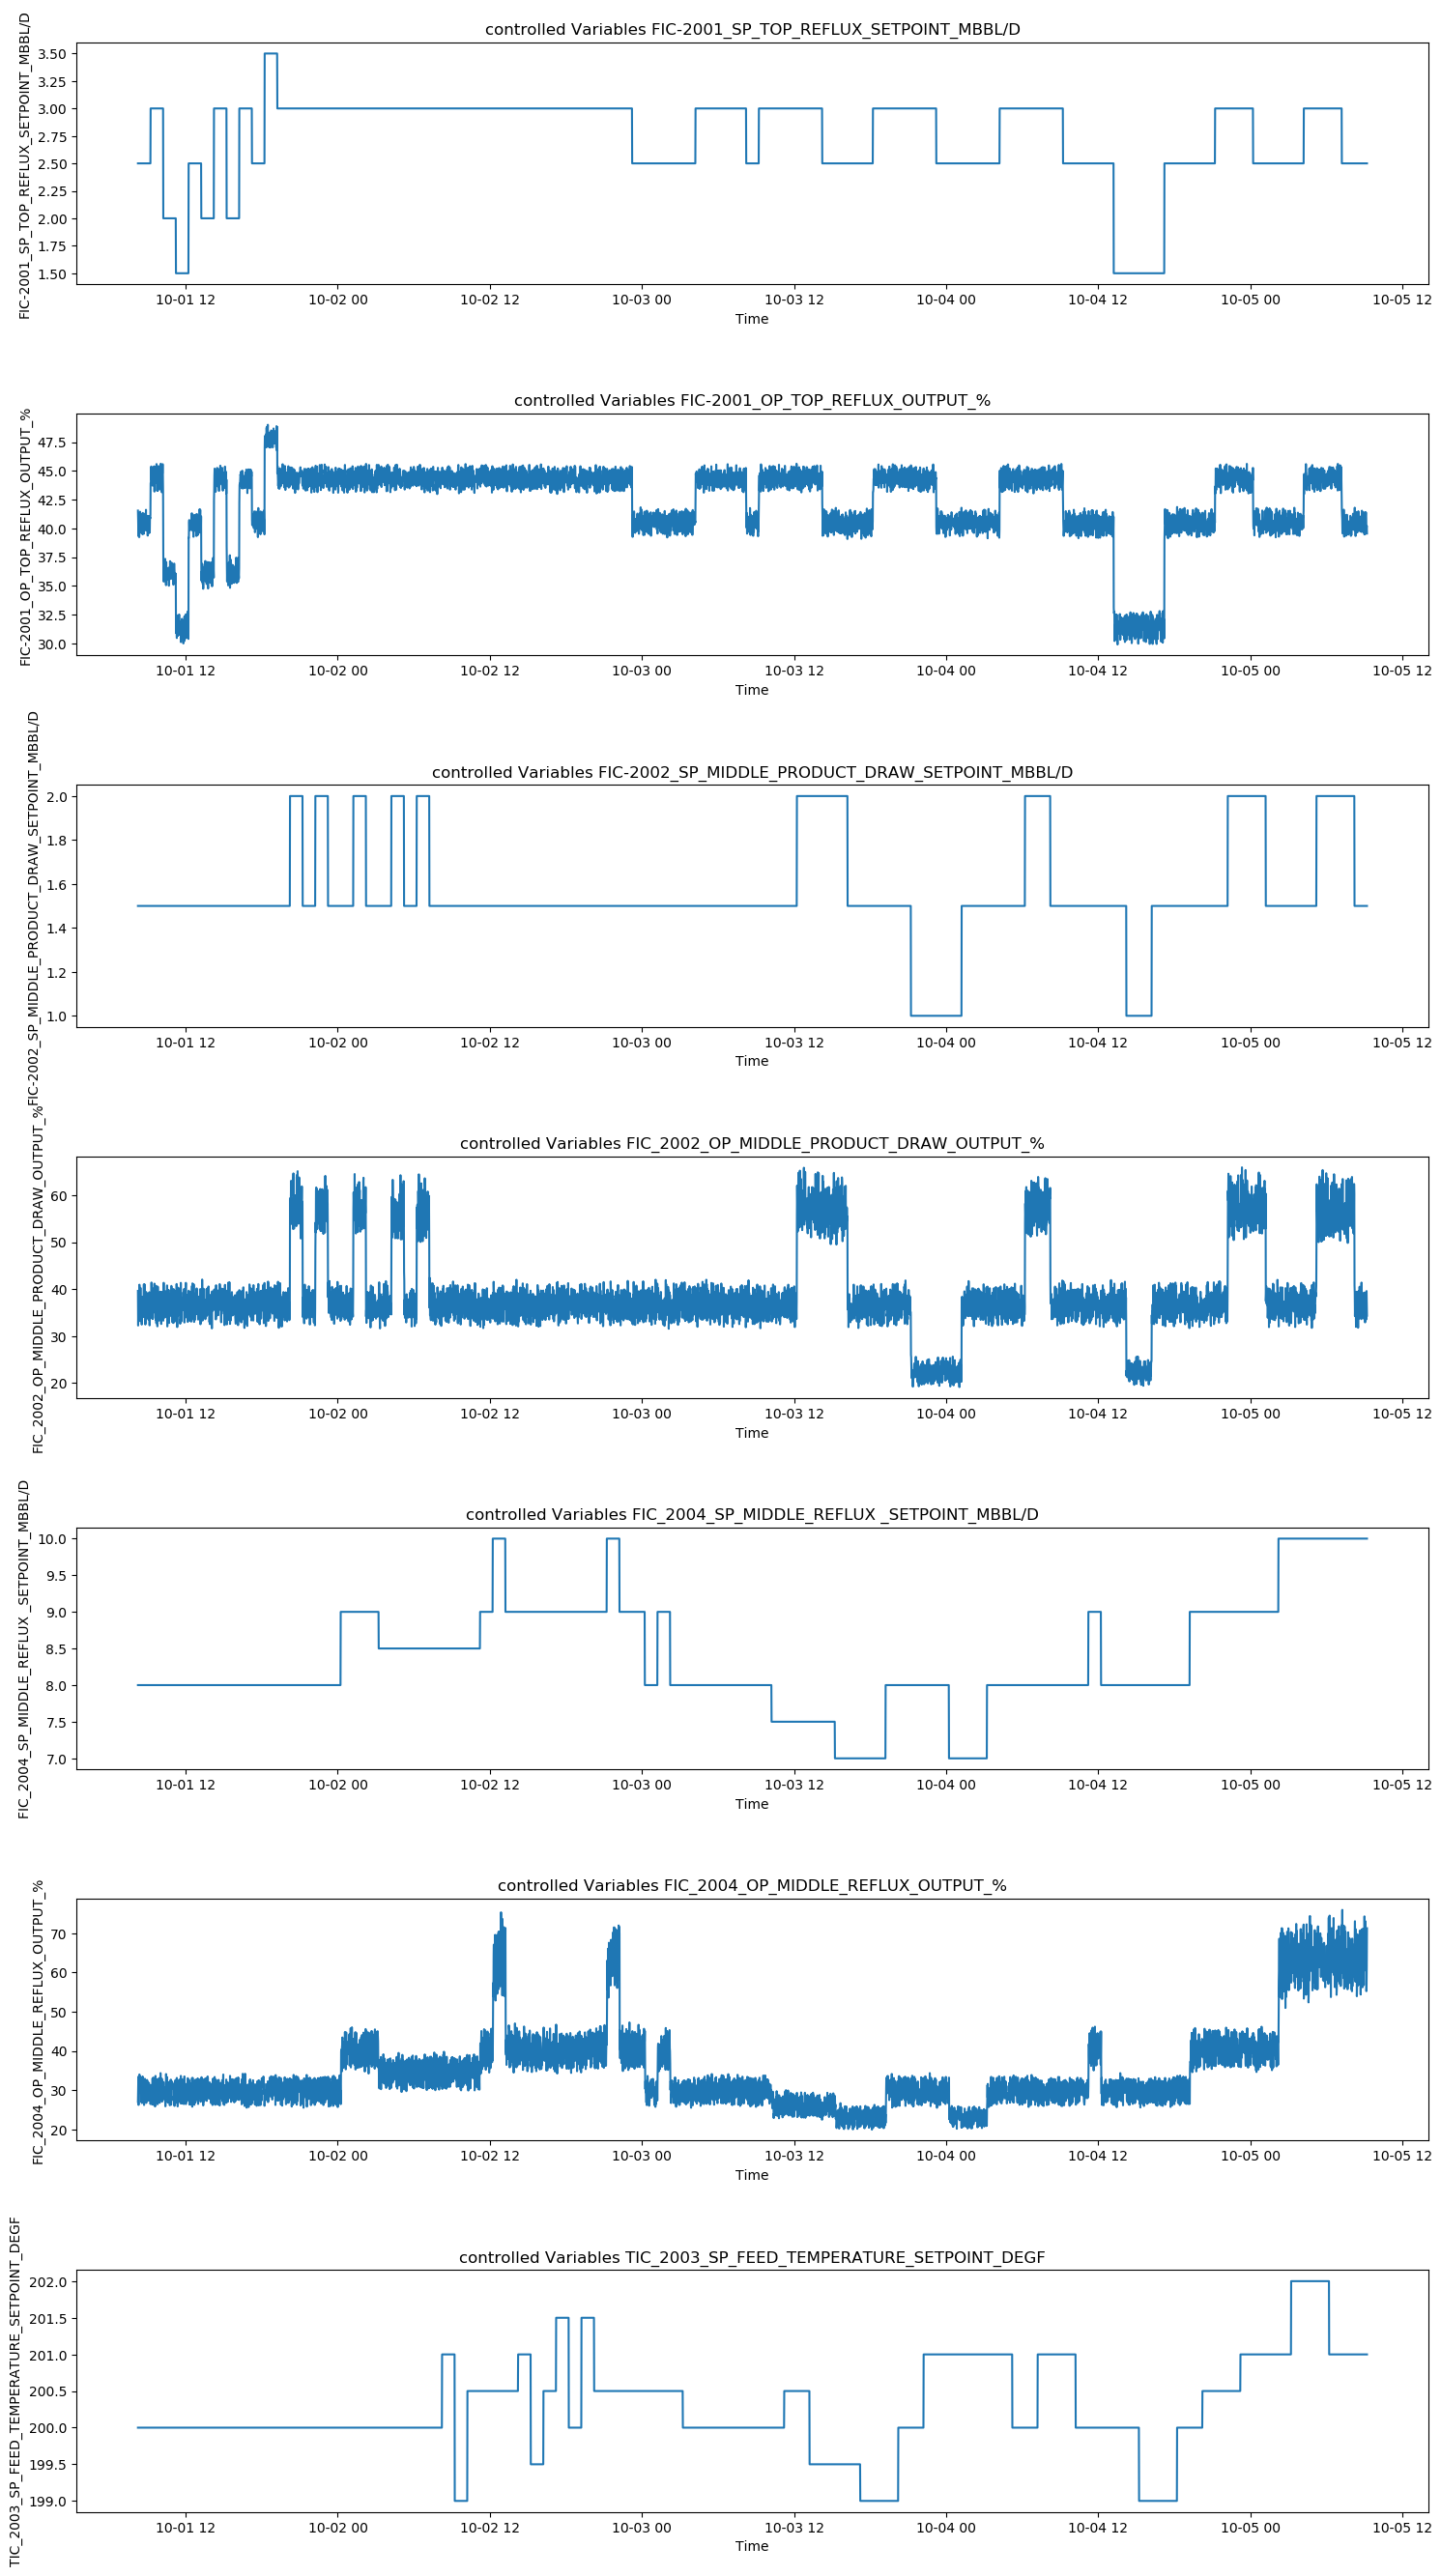

In [14]:
plt.figure(figsize = (15, 30))
plt.title('Controlled Variables')
for i in enumerate(controlled_variables):
    plt.subplot(8, 1,i[0]+1)
    plt.tight_layout(h_pad=0.5)

    plt.plot(df["Time"],df[i[1]])
    
    plt.title('controlled Variables '+i[1])

    plt.xlabel('Time')
    plt.ylabel(df[controlled_variables].columns[i[0]])

plt.savefig('controlled_variables.png')

plt.show()


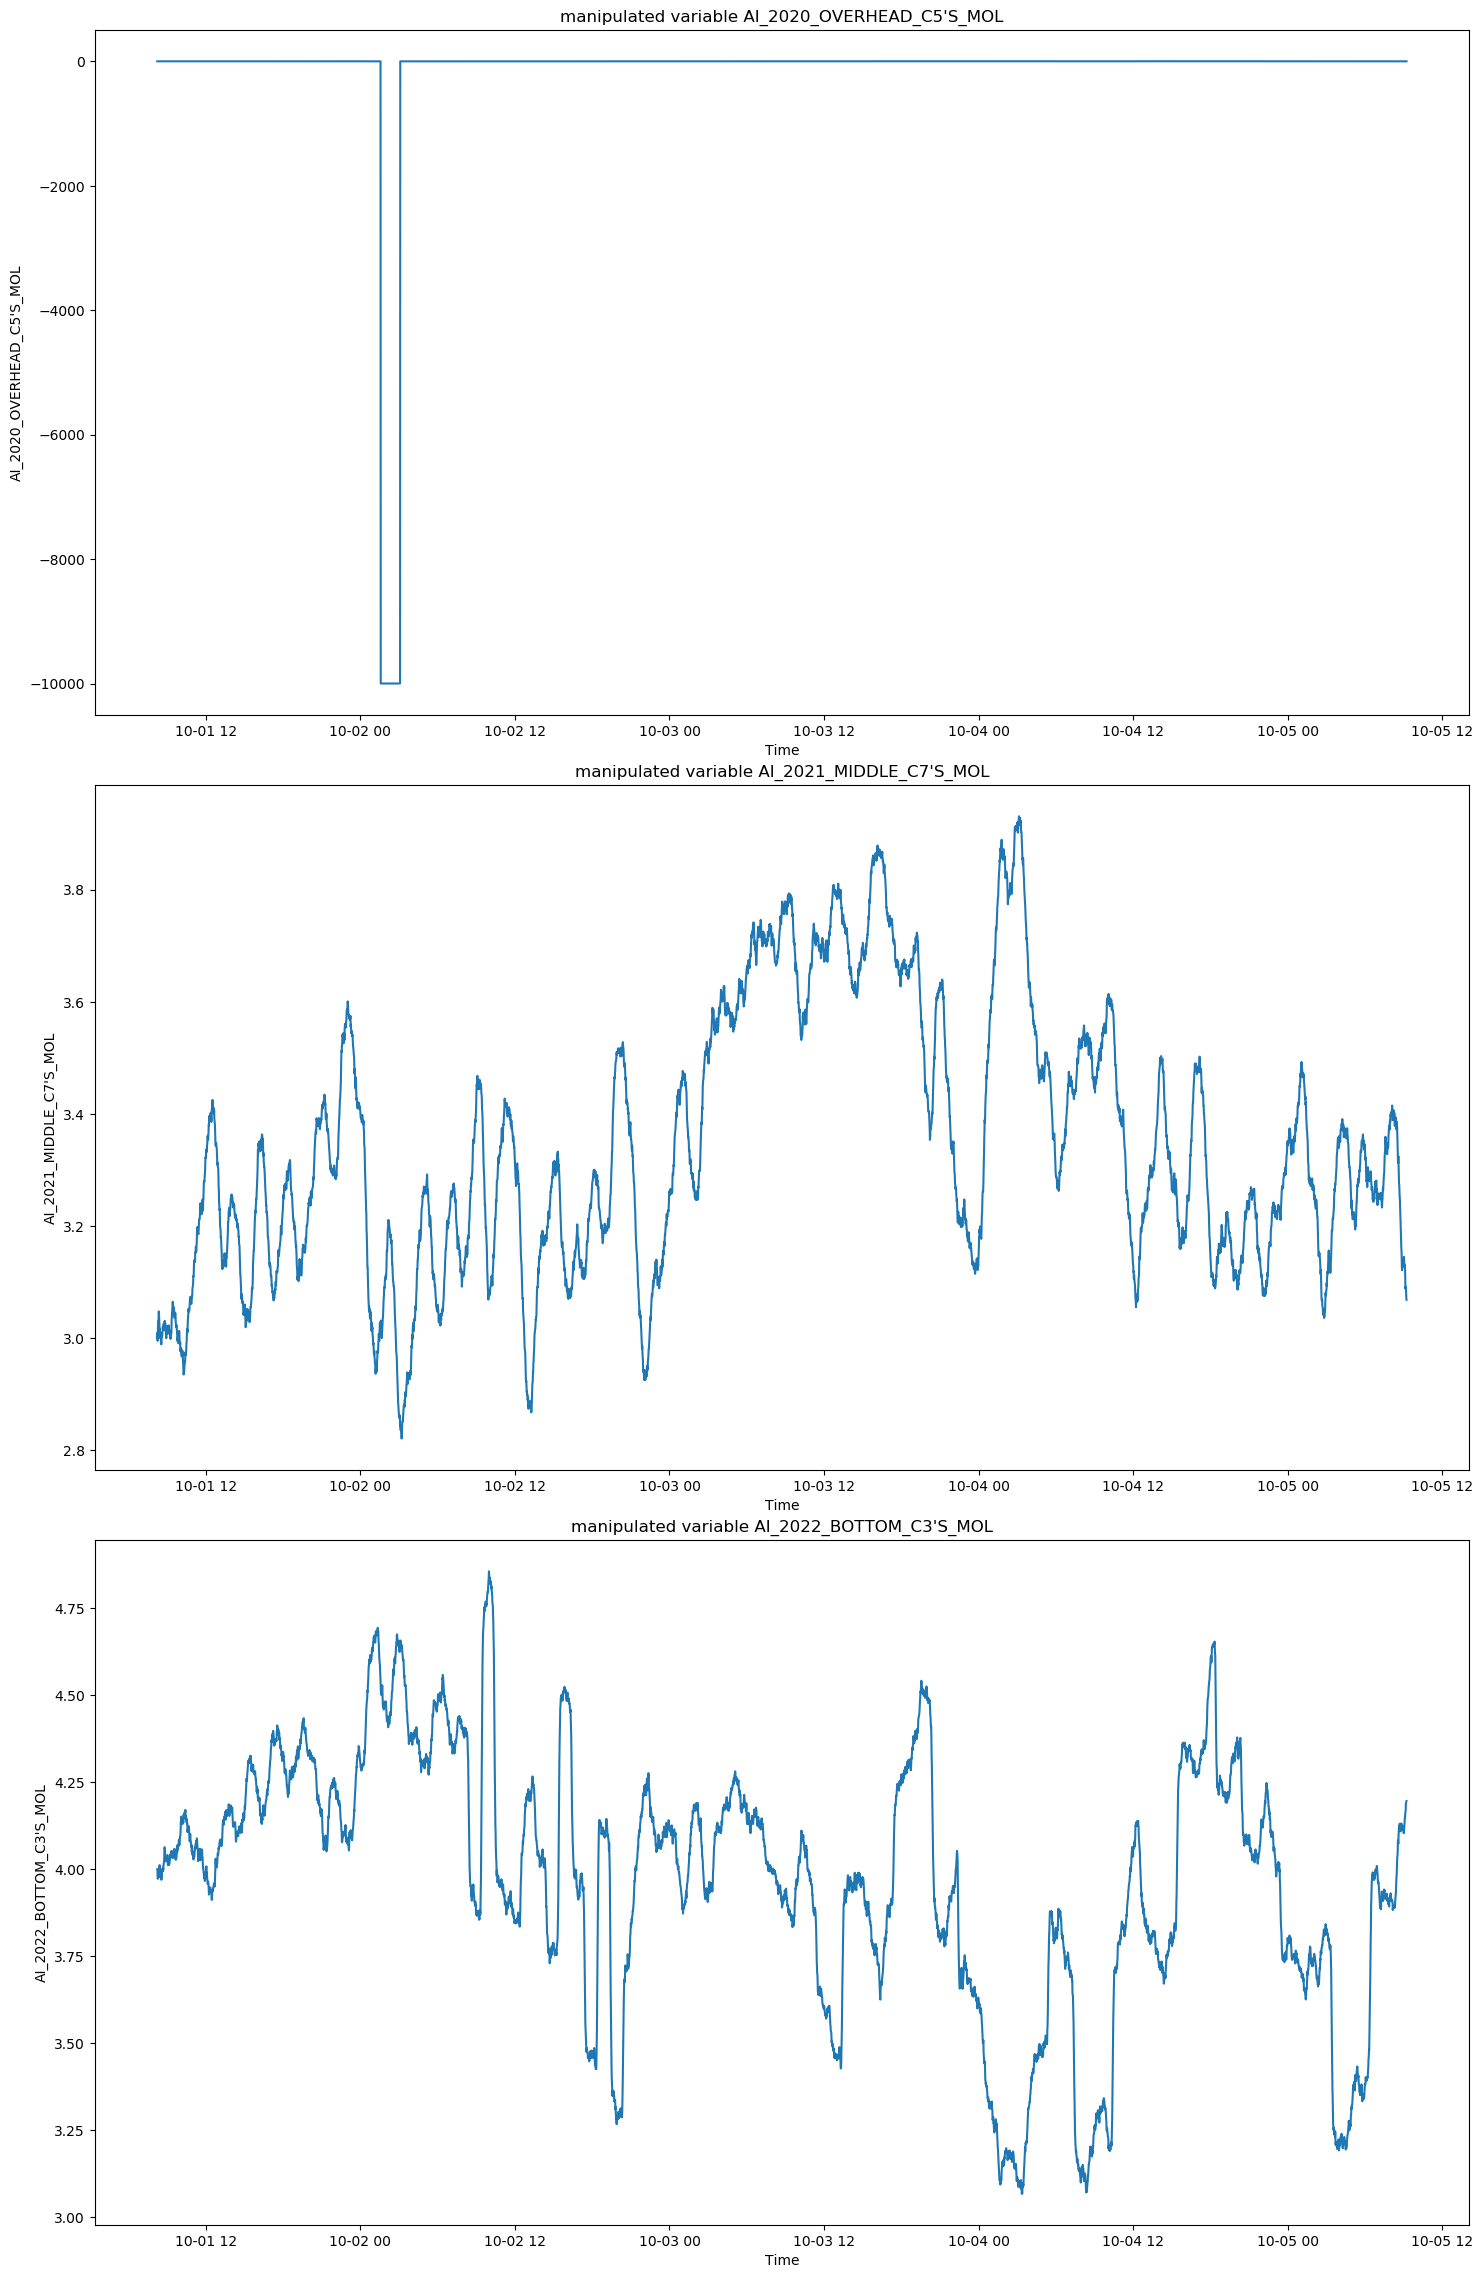

In [15]:
plt.figure(figsize = (15, 30))

for i in enumerate(manipulated_variables):
    plt.subplot(len(manipulated_variables)+1, 1,i[0]+1)
    plt.tight_layout(h_pad=0.5)

    plt.plot(df["Time"],df[i[1]])
    plt.title('manipulated variable '+i[1])
    plt.xlabel('Time')
    plt.ylabel(df[manipulated_variables].columns[i[0]])

plt.savefig('manipulated_variables.png')

plt.show()

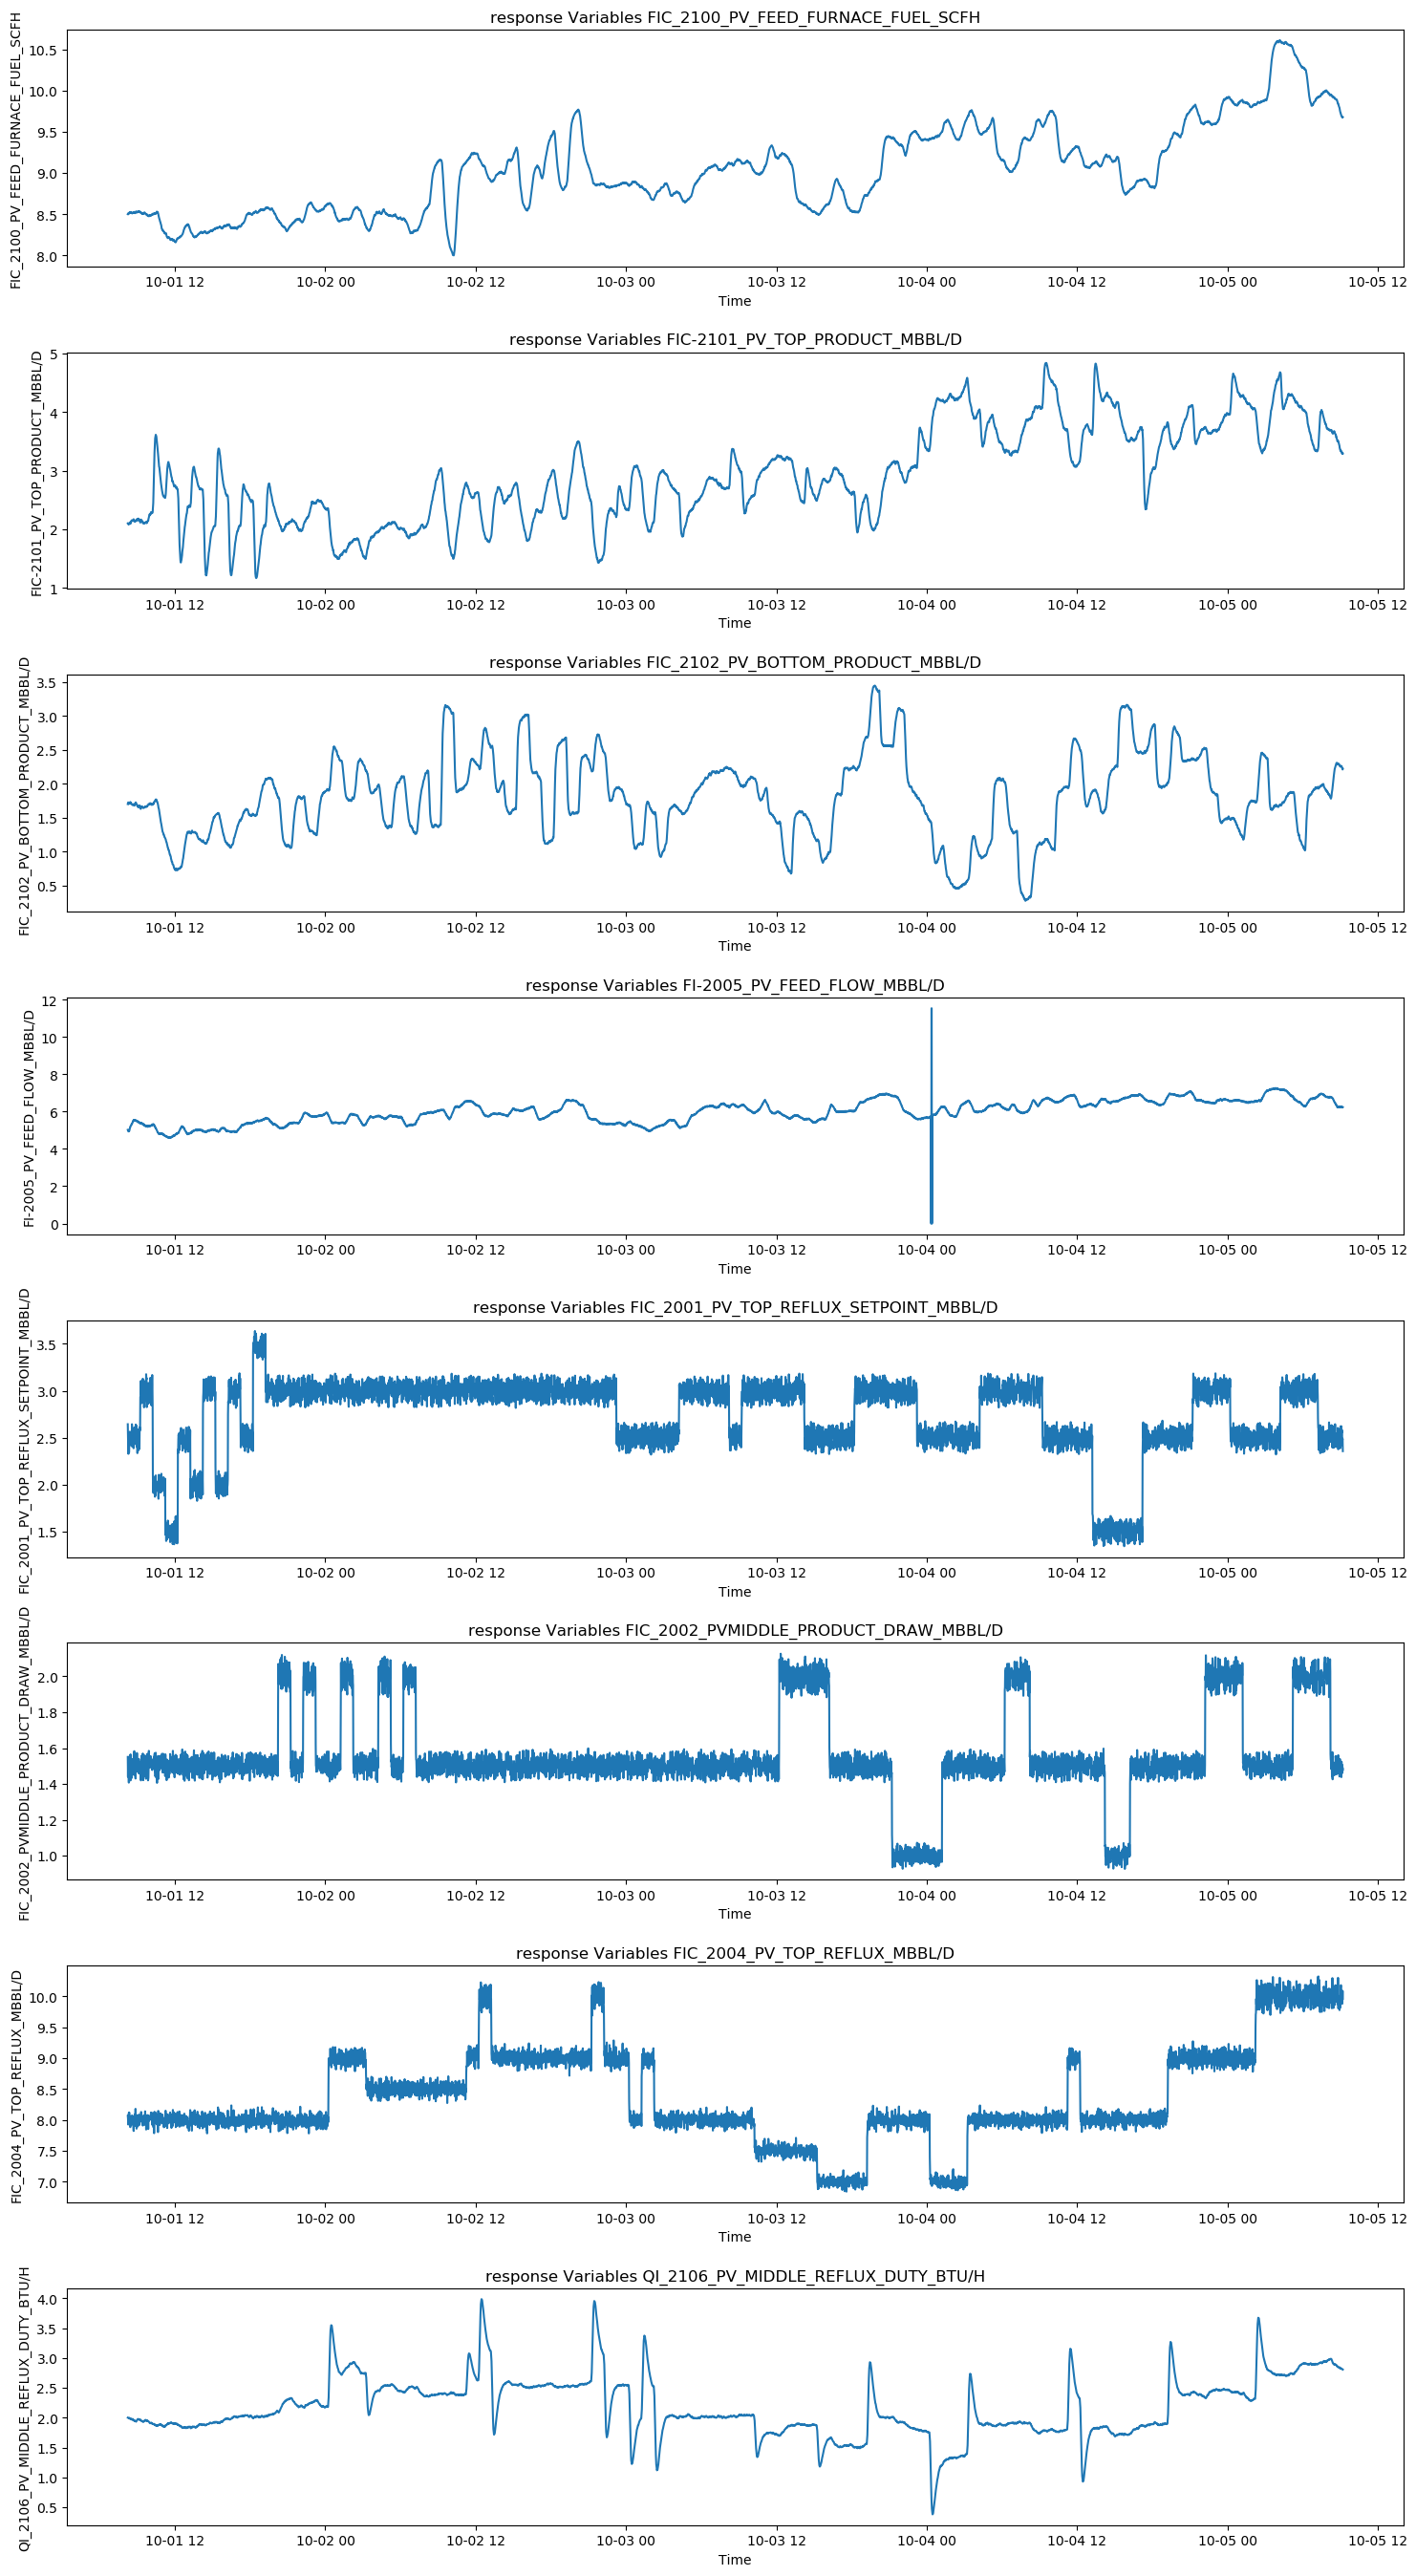

In [16]:
plt.figure(figsize = (15, 30))

for i in enumerate(reponse_variables):
    plt.subplot(len(reponse_variables)+1, 1,i[0]+1)
    plt.tight_layout(h_pad=0.5)

    plt.plot(df["Time"],df[i[1]])
    
    plt.title('response Variables '+i[1])
    plt.xlabel('Time')
    plt.ylabel(df[reponse_variables].columns[i[0]])

plt.savefig('response_variables.png')

plt.show()

## Removing the outliers from the data:

In [17]:
# plotting boxplots for each variable to check for outliers.
df1=df.drop(['Time'],axis=1)

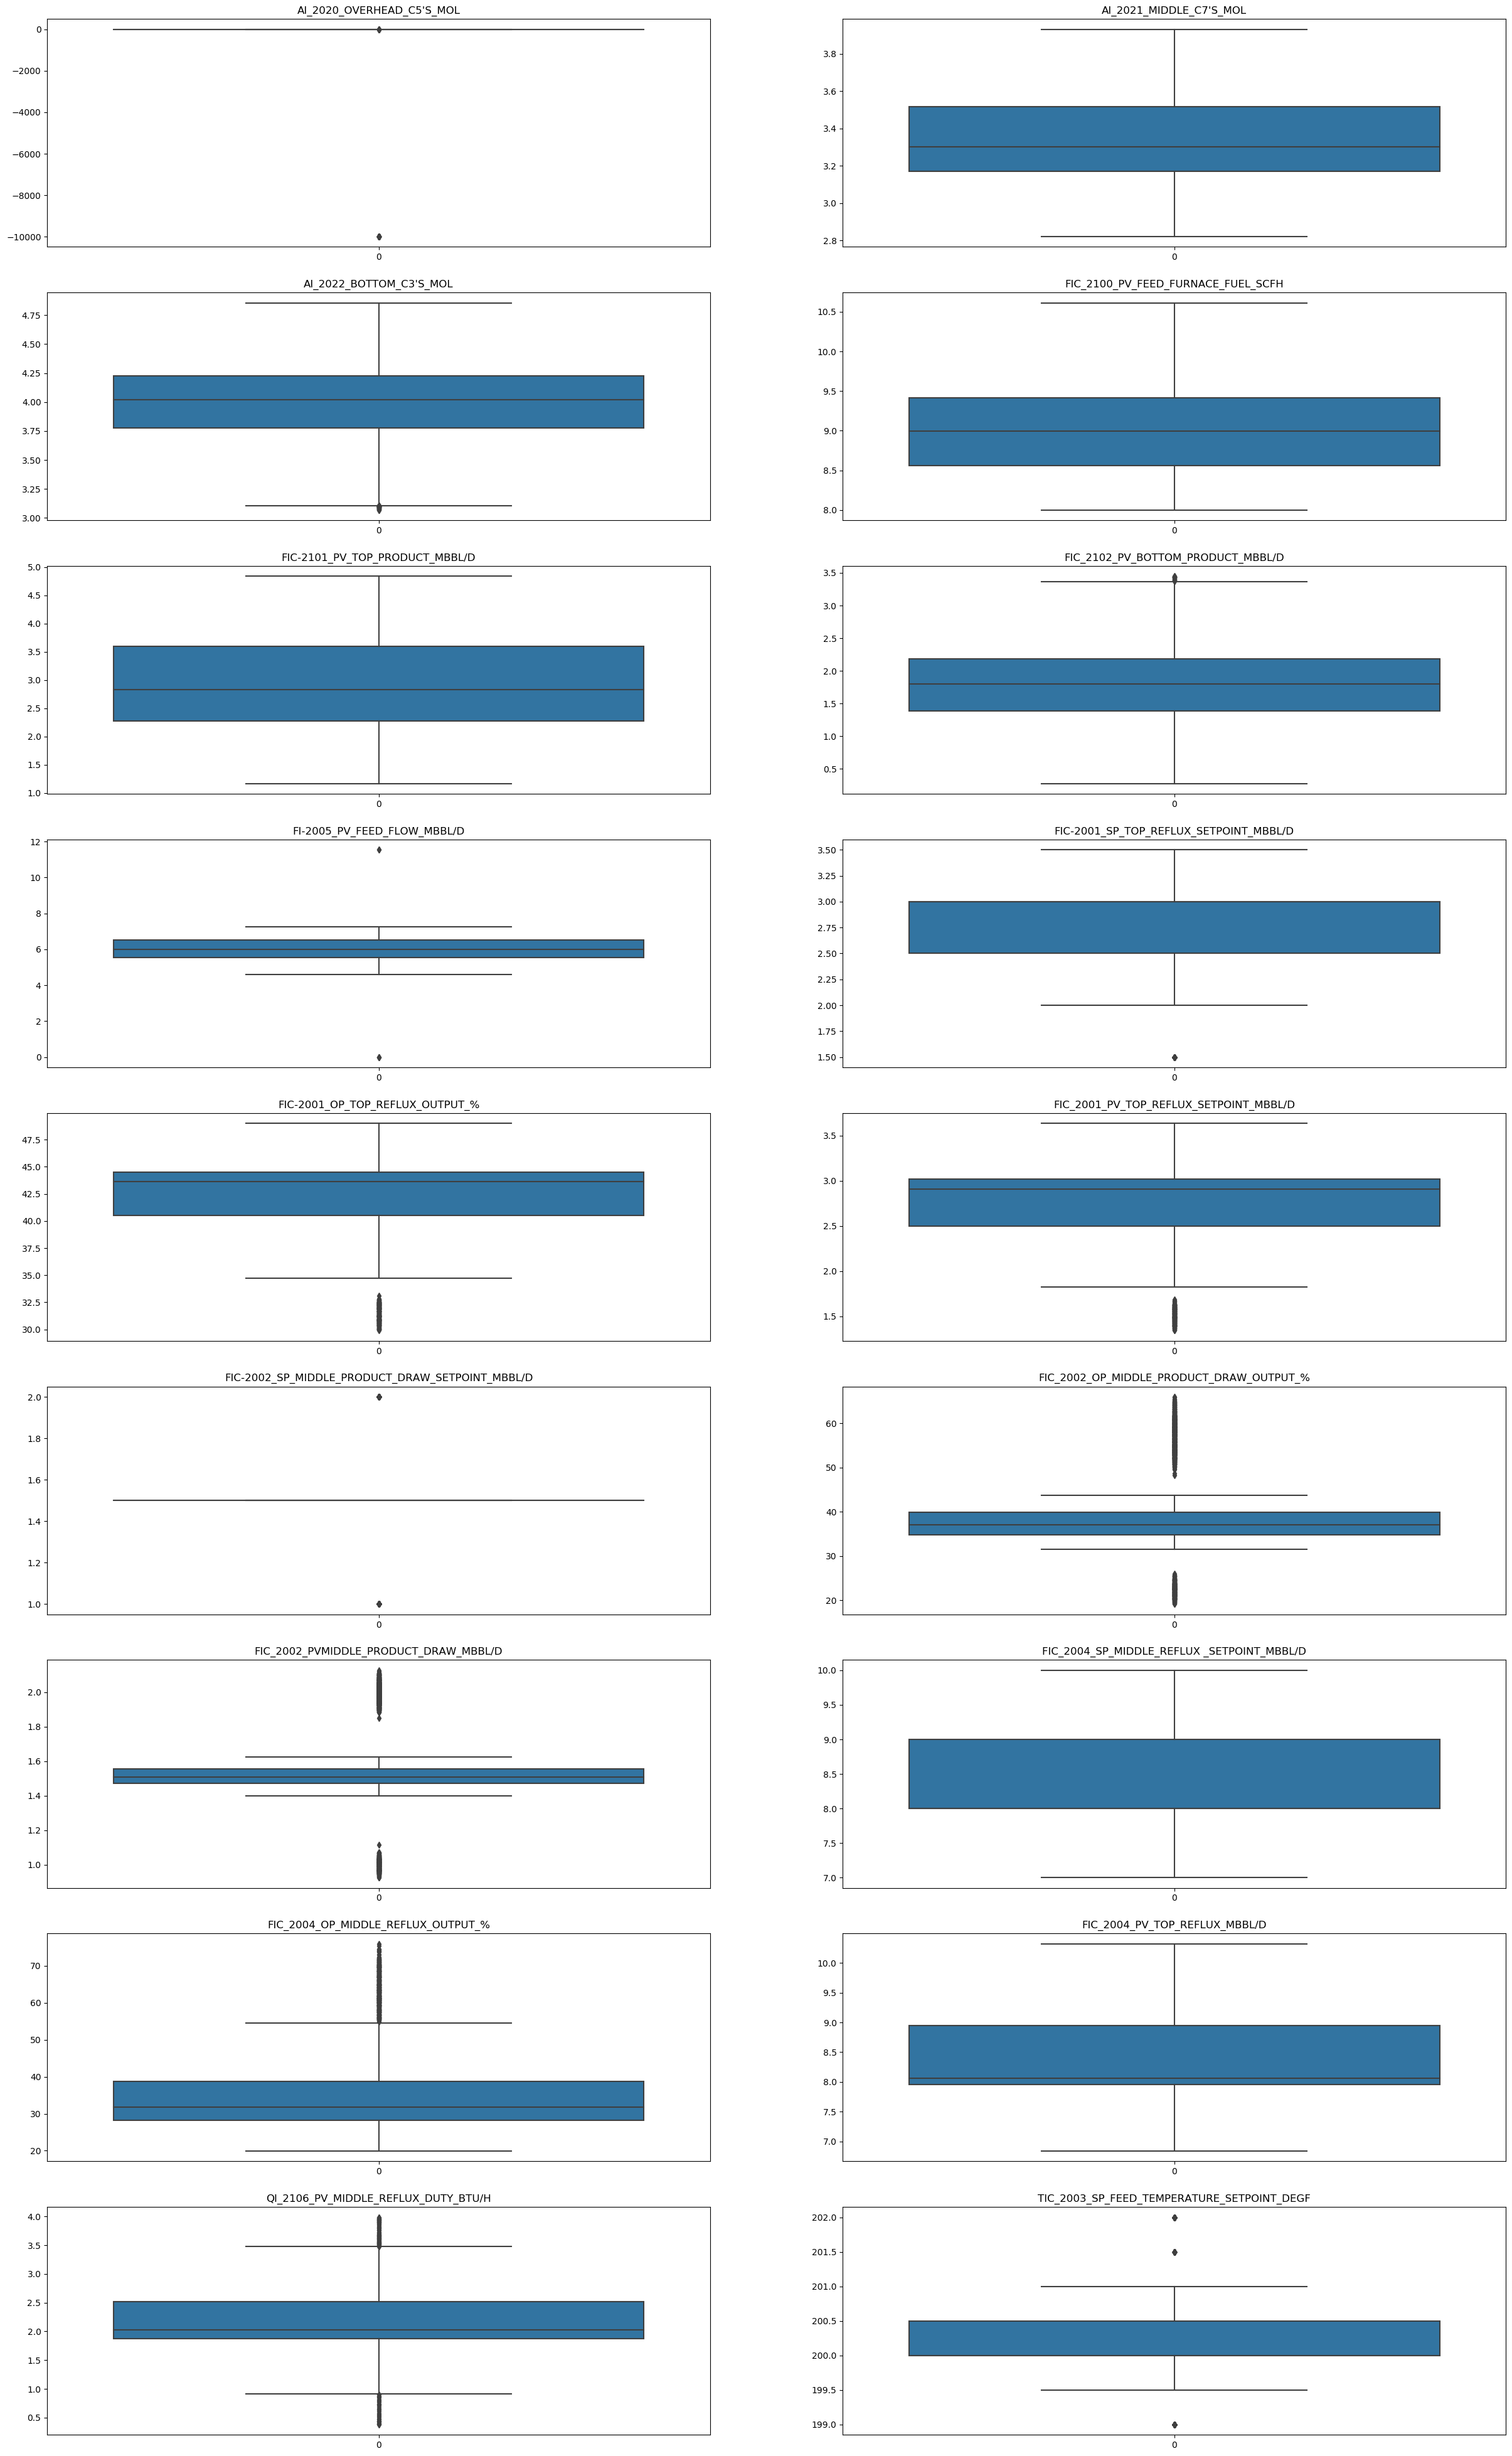

In [18]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(9, 2, figsize=(30, 50))

# Flatten the axis objects to simplify indexing
axs = axs.flatten()

# Create box plots for each column in the DataFrame
for i, col in enumerate(df1.columns):
    fig1=sns.boxplot(data=df[col], ax=axs[i])
    axs[i].set_title(col)

# Hide the remaining subplots
for j in range(len(df1.columns), len(axs)):
    axs[j].axis('off')

# Show the plot
plt.show()
fig1.figure.savefig('outlier detection.png')

### Removing Outliers

In [15]:
# Remove outliers
df=df[(np.abs(stats.zscore(df["AI_2020_OVERHEAD_C5'S_MOL"])) < 3)]

In [16]:
df=df[(np.abs(stats.zscore(df['FI-2005_PV_FEED_FLOW_MBBL/D'])) < 3)]

In [21]:
# plotting boxplots for each variable to check for outliers.
df1=df.drop(['Time'],axis=1)

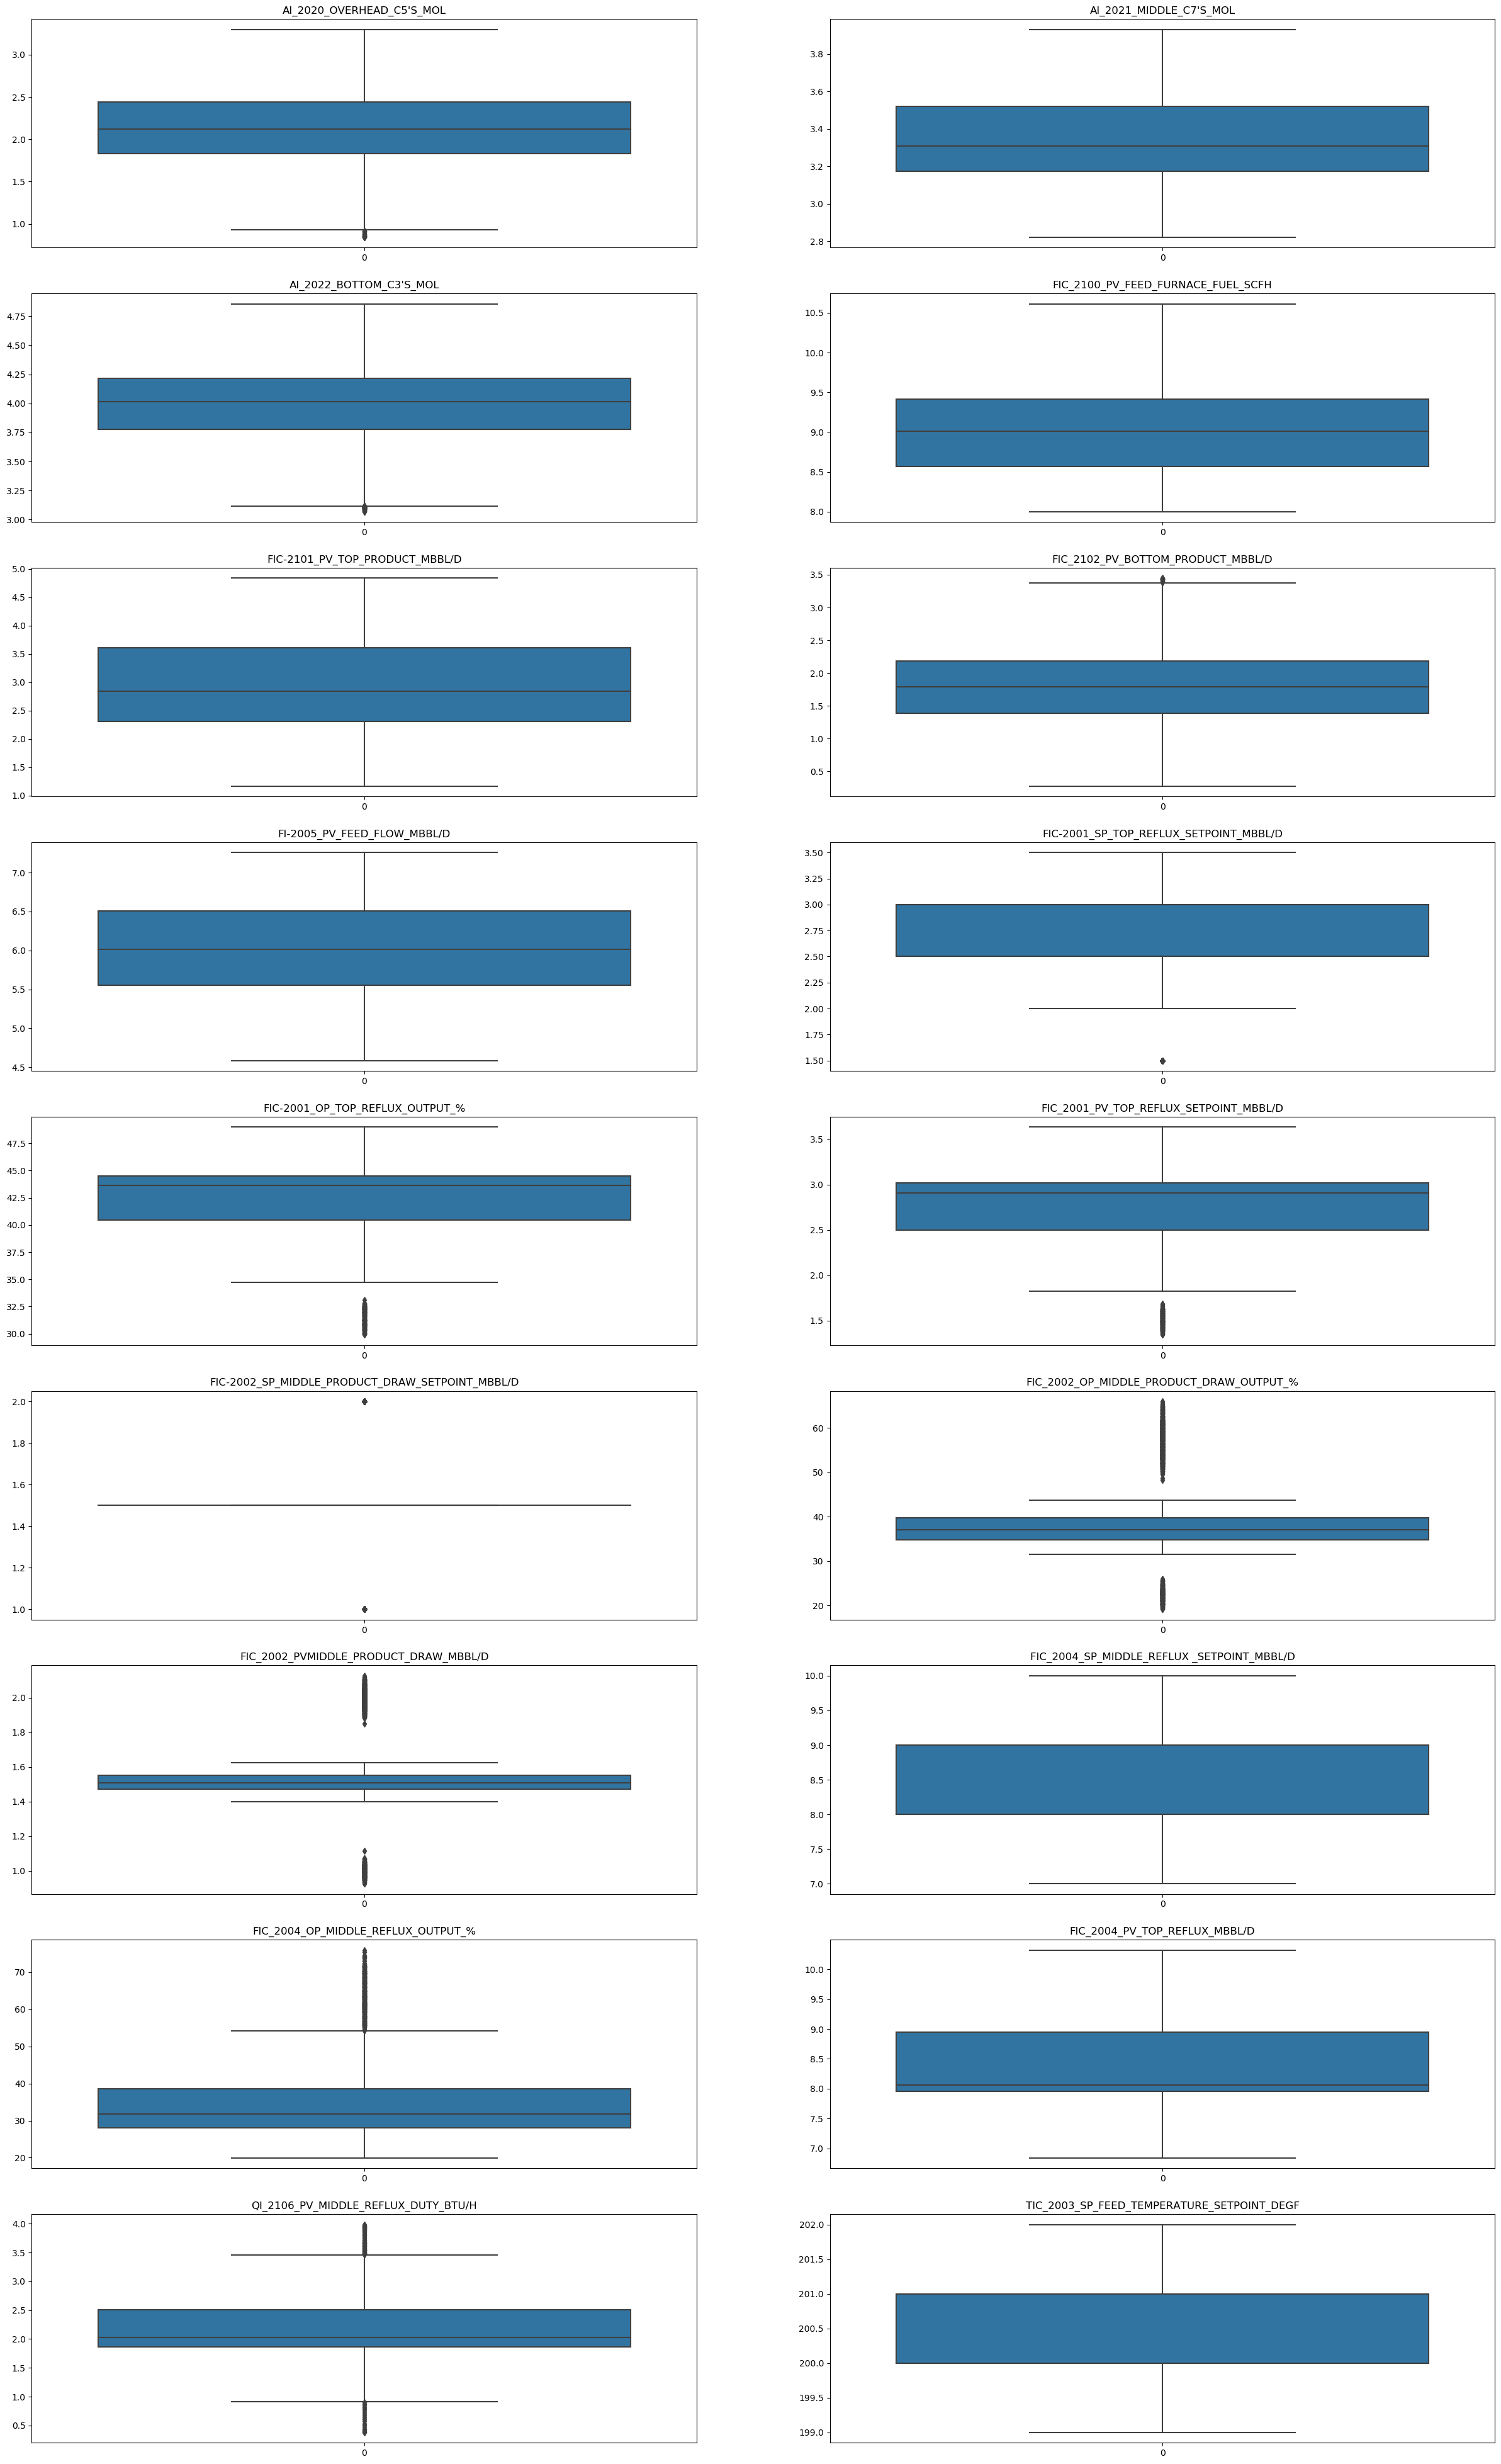

In [22]:
# Create a figure with multiple subplots
fig, axs = plt.subplots(9, 2, figsize=(30, 50))

# Flatten the axis objects to simplify indexing
axs = axs.flatten()

# Create box plots for each column in the DataFrame
for i, col in enumerate(df1.columns):
    fig1=sns.boxplot(data=df[col], ax=axs[i])
    axs[i].set_title(col)

# Hide the remaining subplots
for j in range(len(df1.columns), len(axs)):
    axs[j].axis('off')

# Show the plot
plt.show()
fig1.figure.savefig('outlier removed.png')

In [23]:
outliers_variables=["AI_2020_OVERHEAD_C5'S_MOL",'FI-2005_PV_FEED_FLOW_MBBL/D']

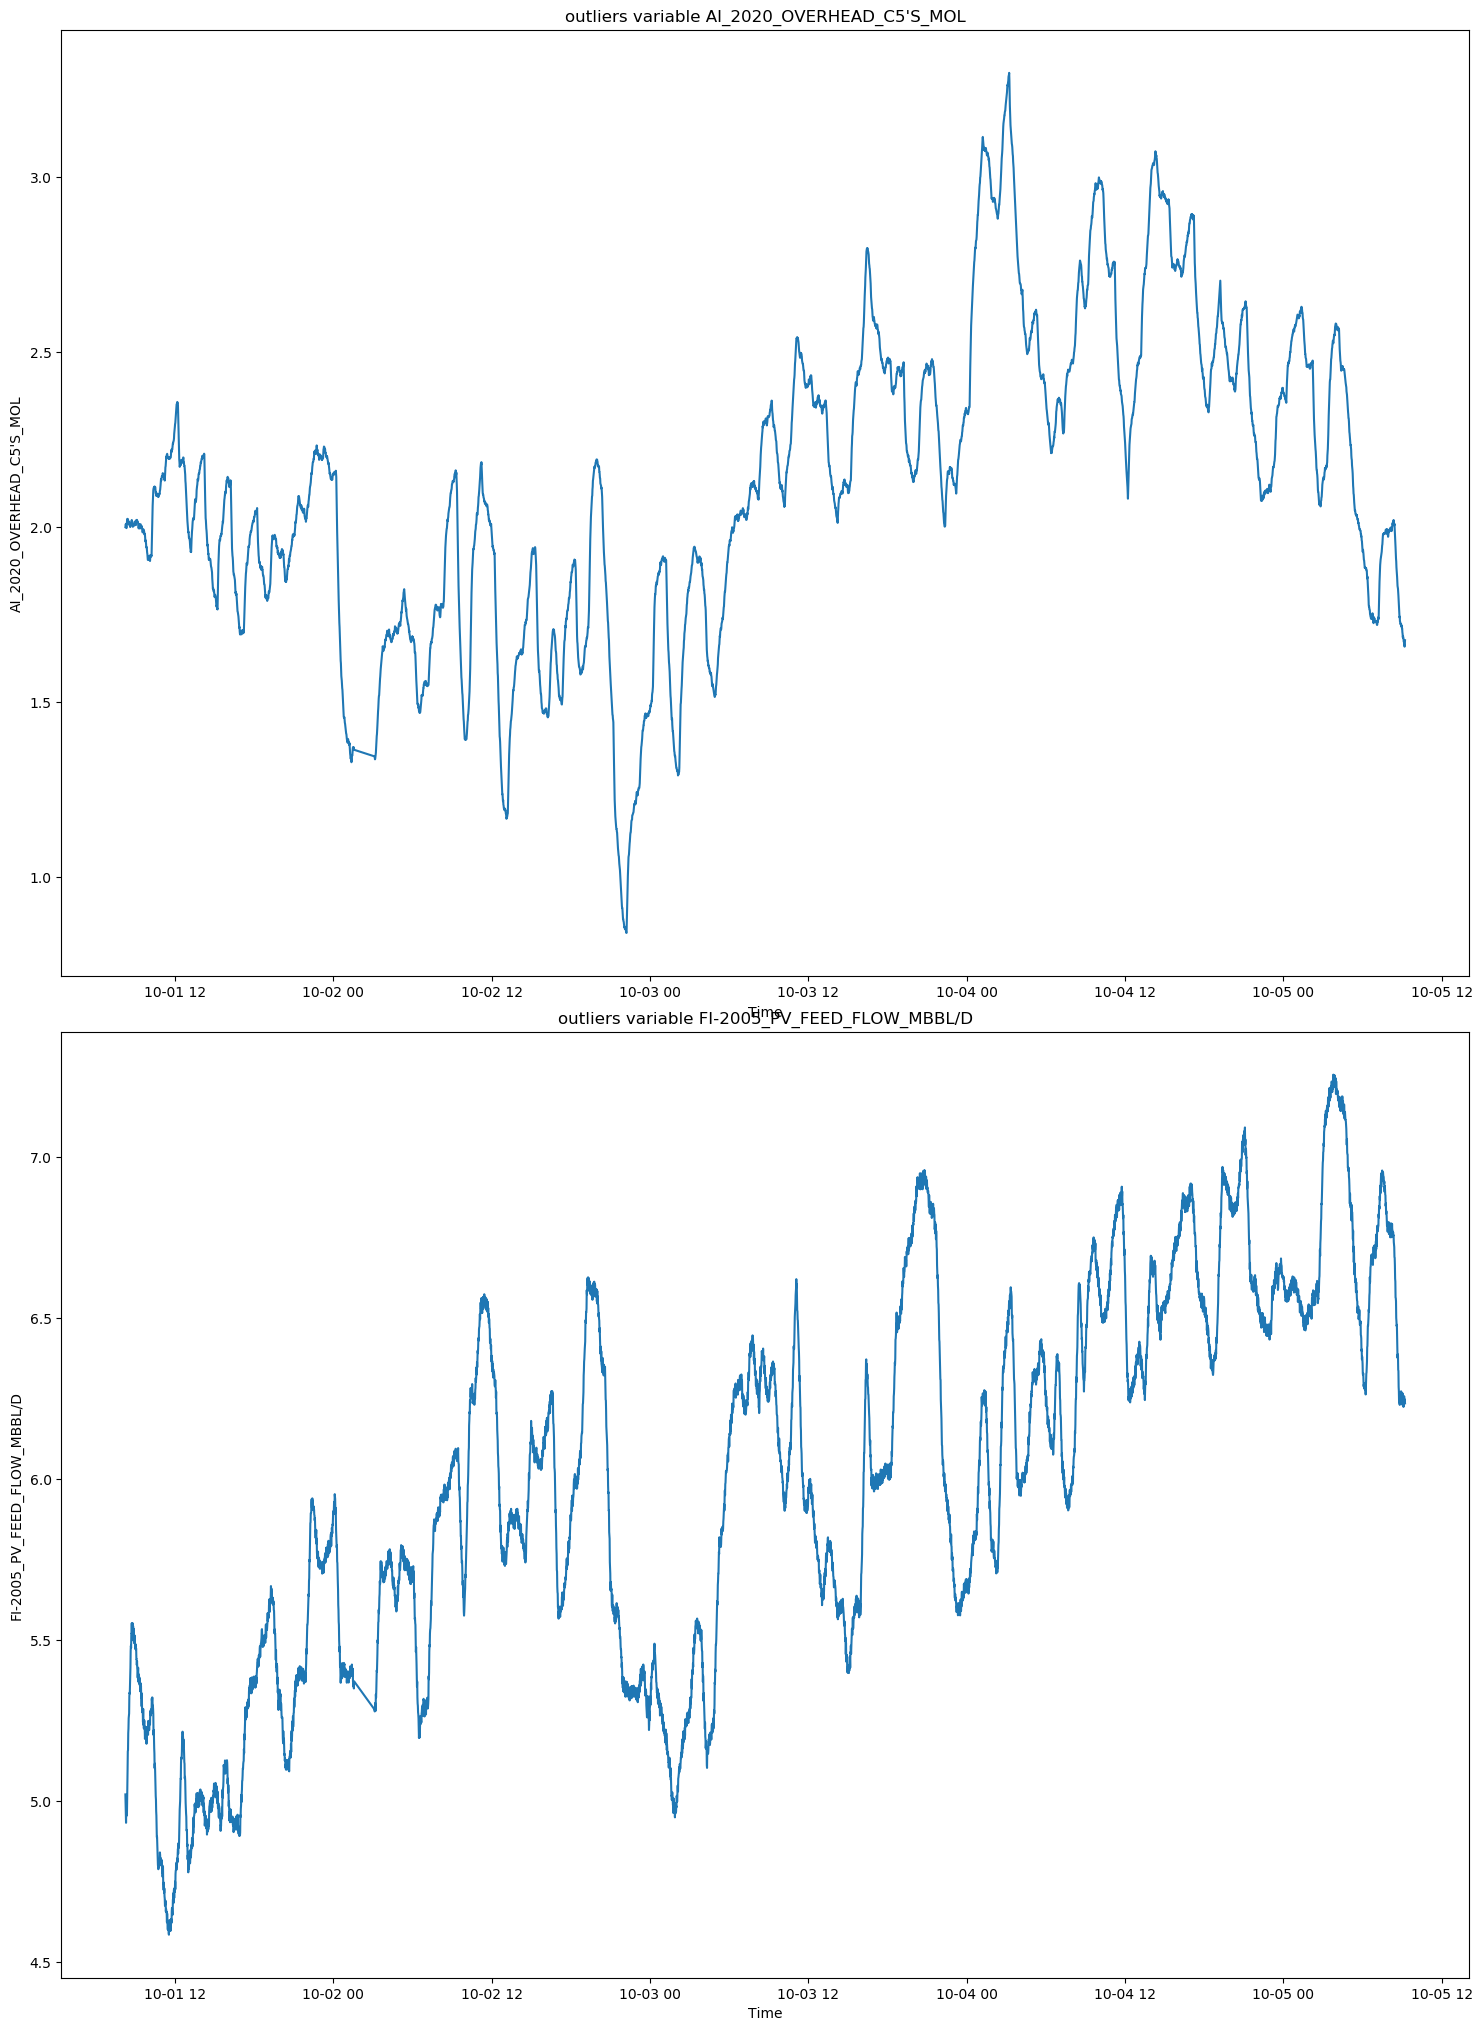

In [24]:
# plotting variables after removing outliers
plt.figure(figsize = (15, 30))

for i in enumerate(outliers_variables):
    plt.subplot(len(outliers_variables)+1, 1,i[0]+1)
    plt.tight_layout(h_pad=0.5)

    plt.plot(df["Time"],df[i[1]])
    plt.title('outliers variable '+i[1])
    plt.xlabel('Time')
    plt.ylabel(df[outliers_variables].columns[i[0]])

plt.savefig('outliers fixed.png')

plt.show()

In [25]:

print('Number of outliers removed:',len(original_data)-len(df))

Number of outliers removed: 97


### Data transformation as required for each project

##### Data transformation and feature engineering for AI_2020_OVERHEAD_C5'S_MOL time series prediction:

In [17]:
df_top=df[["Time","AI_2020_OVERHEAD_C5'S_MOL"]]

In [18]:
df_top.rename(columns={"AI_2020_OVERHEAD_C5'S_MOL": "AI_top"}, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [50]:
df_top.head()

                 Time   AI_top
0 2009-10-01 08:14:00  2.00000
1 2009-10-01 08:15:00  2.00360
2 2009-10-01 08:16:00  2.00870
3 2009-10-01 08:17:00  2.00385
4 2009-10-01 08:18:00  1.99852

,Time,AI_top
0,2009-10-01 08:14:00,2.00000
1,2009-10-01 08:15:00,2.00360
2,2009-10-01 08:16:00,2.00870
3,2009-10-01 08:17:00,2.00385
4,2009-10-01 08:18:00,1.99852


In [52]:
df_top.set_index('Time', inplace=True)
df_top.head()

                      AI_top
Time                        
2009-10-01 08:14:00  2.00000
2009-10-01 08:15:00  2.00360
2009-10-01 08:16:00  2.00870
2009-10-01 08:17:00  2.00385
2009-10-01 08:18:00  1.99852

,AI_top
Time,
2009-10-01 08:14:00,2.00000
2009-10-01 08:15:00,2.00360
2009-10-01 08:16:00,2.00870
2009-10-01 08:17:00,2.00385
2009-10-01 08:18:00,1.99852


In [53]:

# function to creat window for time series processing:
time_df=df_top.copy()
def df_to_X_y(time_df, window_size=10):
  df_np = time_df.to_numpy()
  X = []
  y = []
  for i in range(len(df_np)-window_size):
    row = [r for r in df_np[i:i+window_size]]
    X.append(row)
    label = df_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)


In [54]:
X,y= df_to_X_y(time_df,window_size=10)


In [55]:
y=y.reshape([y.shape[0]])
print(y.shape)
X=X.reshape([X.shape[0],X.shape[1]])
print(X.shape)

(5713,)
(5713, 10)


In [56]:
X_dataframe=pd.DataFrame(X,columns=['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9'])
X_dataframe.head()

        t0       t1       t2       t3       t4       t5       t6       t7  \
0  2.00000  2.00360  2.00870  2.00385  1.99852  1.99710  2.00260  2.01440   
1  2.00360  2.00870  2.00385  1.99852  1.99710  2.00260  2.01440  2.01669   
2  2.00870  2.00385  1.99852  1.99710  2.00260  2.01440  2.01669  2.02368   
3  2.00385  1.99852  1.99710  2.00260  2.01440  2.01669  2.02368  2.01608   
4  1.99852  1.99710  2.00260  2.01440  2.01669  2.02368  2.01608  2.02237   

        t8       t9  
0  2.01669  2.02368  
1  2.02368  2.01608  
2  2.01608  2.02237  
3  2.02237  2.02020  
4  2.02020  2.01924  

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,2.00000,2.00360,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368
1,2.00360,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608
2,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237
3,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237,2.02020
4,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237,2.02020,2.01924


In [57]:
y_dataframe=pd.DataFrame(y,columns=['t10'])
y_dataframe.head()

       t10
0  2.01608
1  2.02237
2  2.02020
3  2.01924
4  2.01335

,t10
0,2.01608
1,2.02237
2,2.02020
3,2.01924
4,2.01335


In [58]:
xy=pd.DataFrame()
xy['t10']=y_dataframe['t10']
xy[['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9']]=X_dataframe[['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9']]
xy.head()


       t10       t0       t1       t2       t3       t4       t5       t6  \
0  2.01608  2.00000  2.00360  2.00870  2.00385  1.99852  1.99710  2.00260   
1  2.02237  2.00360  2.00870  2.00385  1.99852  1.99710  2.00260  2.01440   
2  2.02020  2.00870  2.00385  1.99852  1.99710  2.00260  2.01440  2.01669   
3  2.01924  2.00385  1.99852  1.99710  2.00260  2.01440  2.01669  2.02368   
4  2.01335  1.99852  1.99710  2.00260  2.01440  2.01669  2.02368  2.01608   

        t7       t8       t9  
0  2.01440  2.01669  2.02368  
1  2.01669  2.02368  2.01608  
2  2.02368  2.01608  2.02237  
3  2.01608  2.02237  2.02020  
4  2.02237  2.02020  2.01924  

,t10,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,2.01608,2.00000,2.00360,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368
1,2.02237,2.00360,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608
2,2.02020,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237
3,2.01924,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237,2.02020
4,2.01335,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237,2.02020,2.01924


In [46]:
df_data_features=xy.iloc[:,1:]
df_data_features

           t0       t1       t2       t3       t4       t5       t6       t7  \
0     2.00000  2.00360  2.00870  2.00385  1.99852  1.99710  2.00260  2.01440   
1     2.00360  2.00870  2.00385  1.99852  1.99710  2.00260  2.01440  2.01669   
2     2.00870  2.00385  1.99852  1.99710  2.00260  2.01440  2.01669  2.02368   
3     2.00385  1.99852  1.99710  2.00260  2.01440  2.01669  2.02368  2.01608   
4     1.99852  1.99710  2.00260  2.01440  2.01669  2.02368  2.01608  2.02237   
...       ...      ...      ...      ...      ...      ...      ...      ...   
5708  1.71108  1.71109  1.69975  1.69506  1.68498  1.68894  1.68242  1.68244   
5709  1.71109  1.69975  1.69506  1.68498  1.68894  1.68242  1.68244  1.67338   
5710  1.69975  1.69506  1.68498  1.68894  1.68242  1.68244  1.67338  1.67325   
5711  1.69506  1.68498  1.68894  1.68242  1.68244  1.67338  1.67325  1.66446   
5712  1.68498  1.68894  1.68242  1.68244  1.67338  1.67325  1.66446  1.66227   

           t8       t9  
0     2.01669 

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,2.00000,2.00360,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368
1,2.00360,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608
2,2.00870,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237
3,2.00385,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237,2.02020
4,1.99852,1.99710,2.00260,2.01440,2.01669,2.02368,2.01608,2.02237,2.02020,2.01924
...,...,...,...,...,...,...,...,...,...,...
5708,1.71108,1.71109,1.69975,1.69506,1.68498,1.68894,1.68242,1.68244,1.67338,1.67325
5709,1.71109,1.69975,1.69506,1.68498,1.68894,1.68242,1.68244,1.67338,1.67325,1.66446
5710,1.69975,1.69506,1.68498,1.68894,1.68242,1.68244,1.67338,1.67325,1.66446,1.66227
5711,1.69506,1.68498,1.68894,1.68242,1.68244,1.67338,1.67325,1.66446,1.66227,1.65845


#### Splitting the data into train and test
> for time series data we should not split the data using shuffle.

In [76]:
#splitting the data into train and test
train_split_index = int(len(xy) * 0.6)

train_split_index

3427

In [72]:
train_data=xy.iloc[:train_split_index,:]
testing_data=xy.iloc[train_split_index:,:]
print(train_data.shape,test_data.shape)

(3427, 11) (2286, 11)


In [122]:
# splitting the test data into valid and test
valid_split_index = int(len(testing_data) * 0.5)

valid_split_index

1143

In [74]:
valid_data=testing_data.iloc[:valid_split_index,:]
test_data=testing_data.iloc[valid_split_index:,:]


In [75]:
print(train_data.shape,valid_data.shape,test_data.shape)

(3427, 11) (1143, 11) (1143, 11)


## Set up S3

In [77]:
s3=boto3.resource('s3')

In [78]:
bucket_name='fractionatordata'
try:
    s3.create_bucket(Bucket=bucket_name)
    print("S3 bucket {} was created".format(bucket_name))
except Exception as e:
    print("S3 error: ",e)

S3 bucket fractionatordata was created


In [79]:
# Print out bucket names
for bucket in s3.buckets.all():
    print(bucket.name)

fractionatordata
sagemaker-studio-474399255424-6nbx7fc2uhx
sagemaker-studio-dnrvfns8q74
sagemaker-us-east-1-474399255424


In [80]:
import os

### Creating files in s3 for each project for train,val,test and output path for the models

In [144]:
prefix="Ai_top"

In [83]:
train_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'train','train.csv')
val_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'val','val.csv')
test_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'test','test.csv')
print(train_csv_path)
print(val_csv_path)
print(test_csv_path)

s3://fractionatordata/Ai_top/train/train.csv
s3://fractionatordata/Ai_top/val/val.csv
s3://fractionatordata/Ai_top/test/test.csv


In [84]:
train_data.to_csv(train_csv_path,index=False,header=False)
valid_data.to_csv(val_csv_path,index=False,header=False)
test_data.to_csv(test_csv_path,index=False,header=False)

In [146]:
top_output_path="s3://{}/{}/{}/".format(bucket_name,prefix,'output')
print(top_output_path)

s3://fractionatordata/Ai_top/output/


##### Data transformation and feature engineering for AI_2021_MIDDLE_C7'S_MOL time series prediction:

In [86]:
df.columns

Index(['AI_2020_OVERHEAD_C5'S_MOL', 'AI_2021_MIDDLE_C7'S_MOL',
       'AI_2022_BOTTOM_C3'S_MOL', 'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH',
       'FIC-2101_PV_TOP_PRODUCT_MBBL/D', 'FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D',
       'FI-2005_PV_FEED_FLOW_MBBL/D', 'FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC-2001_OP_TOP_REFLUX_OUTPUT_%',
       'FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D',
       'FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%',
       'FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D',
       'FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D',
       'FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%', 'FIC_2004_PV_TOP_REFLUX_MBBL/D',
       'QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H',
       'TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF'],
      dtype='object')

In [88]:
df_middle=df[["AI_2021_MIDDLE_C7'S_MOL"]]

In [89]:
df_middle.rename(columns={"AI_2021_MIDDLE_C7'S_MOL": "AI_middle"}, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
df_middle.head()

                     AI_middle
Time                          
2009-10-01 08:14:00    3.00000
2009-10-01 08:15:00    3.00954
2009-10-01 08:16:00    2.99518
2009-10-01 08:17:00    3.01356
2009-10-01 08:18:00    3.02963

,AI_middle
Time,
2009-10-01 08:14:00,3.00000
2009-10-01 08:15:00,3.00954
2009-10-01 08:16:00,2.99518
2009-10-01 08:17:00,3.01356
2009-10-01 08:18:00,3.02963


In [91]:
time_df=df_middle.copy()

In [92]:

# function to creat window for time series processing:

def df_to_X_y(time_df, window_size=10):
  df_np = time_df.to_numpy()
  X = []
  y = []
  for i in range(len(df_np)-window_size):
    row = [r for r in df_np[i:i+window_size]]
    X.append(row)
    label = df_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)


In [93]:
X,y= df_to_X_y(time_df,window_size=10)


In [94]:
y=y.reshape([y.shape[0]])
print(y.shape)
X=X.reshape([X.shape[0],X.shape[1]])
print(X.shape)

(5713,)
(5713, 10)


In [95]:
X_dataframe=pd.DataFrame(X,columns=['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9'])
X_dataframe.head()

        t0       t1       t2       t3       t4       t5       t6       t7  \
0  3.00000  3.00954  2.99518  3.01356  3.02963  3.02570  3.03318  3.04752   
1  3.00954  2.99518  3.01356  3.02963  3.02570  3.03318  3.04752  3.04477   
2  2.99518  3.01356  3.02963  3.02570  3.03318  3.04752  3.04477  3.03585   
3  3.01356  3.02963  3.02570  3.03318  3.04752  3.04477  3.03585  3.02373   
4  3.02963  3.02570  3.03318  3.04752  3.04477  3.03585  3.02373  3.01583   

        t8       t9  
0  3.04477  3.03585  
1  3.03585  3.02373  
2  3.02373  3.01583  
3  3.01583  3.01609  
4  3.01609  3.00477  

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,3.00000,3.00954,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585
1,3.00954,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373
2,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583
3,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583,3.01609
4,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583,3.01609,3.00477


In [96]:
y_dataframe=pd.DataFrame(y,columns=['t10'])
y_dataframe.head()

       t10
0  3.02373
1  3.01583
2  3.01609
3  3.00477
4  2.99987

,t10
0,3.02373
1,3.01583
2,3.01609
3,3.00477
4,2.99987


In [97]:
xy=pd.DataFrame()
xy['t10']=y_dataframe['t10']
xy[['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9']]=X_dataframe[['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9']]
xy.head()


       t10       t0       t1       t2       t3       t4       t5       t6  \
0  3.02373  3.00000  3.00954  2.99518  3.01356  3.02963  3.02570  3.03318   
1  3.01583  3.00954  2.99518  3.01356  3.02963  3.02570  3.03318  3.04752   
2  3.01609  2.99518  3.01356  3.02963  3.02570  3.03318  3.04752  3.04477   
3  3.00477  3.01356  3.02963  3.02570  3.03318  3.04752  3.04477  3.03585   
4  2.99987  3.02963  3.02570  3.03318  3.04752  3.04477  3.03585  3.02373   

        t7       t8       t9  
0  3.04752  3.04477  3.03585  
1  3.04477  3.03585  3.02373  
2  3.03585  3.02373  3.01583  
3  3.02373  3.01583  3.01609  
4  3.01583  3.01609  3.00477  

,t10,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,3.02373,3.00000,3.00954,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585
1,3.01583,3.00954,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373
2,3.01609,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583
3,3.00477,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583,3.01609
4,2.99987,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583,3.01609,3.00477


In [98]:
df_data_features=xy.iloc[:,1:]
df_data_features

           t0       t1       t2       t3       t4       t5       t6       t7  \
0     3.00000  3.00954  2.99518  3.01356  3.02963  3.02570  3.03318  3.04752   
1     3.00954  2.99518  3.01356  3.02963  3.02570  3.03318  3.04752  3.04477   
2     2.99518  3.01356  3.02963  3.02570  3.03318  3.04752  3.04477  3.03585   
3     3.01356  3.02963  3.02570  3.03318  3.04752  3.04477  3.03585  3.02373   
4     3.02963  3.02570  3.03318  3.04752  3.04477  3.03585  3.02373  3.01583   
...       ...      ...      ...      ...      ...      ...      ...      ...   
5708  3.13528  3.13782  3.14492  3.13416  3.12745  3.13155  3.12551  3.12529   
5709  3.13782  3.14492  3.13416  3.12745  3.13155  3.12551  3.12529  3.10101   
5710  3.14492  3.13416  3.12745  3.13155  3.12551  3.12529  3.10101  3.08810   
5711  3.13416  3.12745  3.13155  3.12551  3.12529  3.10101  3.08810  3.09194   
5712  3.12745  3.13155  3.12551  3.12529  3.10101  3.08810  3.09194  3.09083   

           t8       t9  
0     3.04477 

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,3.00000,3.00954,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585
1,3.00954,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373
2,2.99518,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583
3,3.01356,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583,3.01609
4,3.02963,3.02570,3.03318,3.04752,3.04477,3.03585,3.02373,3.01583,3.01609,3.00477
...,...,...,...,...,...,...,...,...,...,...
5708,3.13528,3.13782,3.14492,3.13416,3.12745,3.13155,3.12551,3.12529,3.10101,3.08810
5709,3.13782,3.14492,3.13416,3.12745,3.13155,3.12551,3.12529,3.10101,3.08810,3.09194
5710,3.14492,3.13416,3.12745,3.13155,3.12551,3.12529,3.10101,3.08810,3.09194,3.09083
5711,3.13416,3.12745,3.13155,3.12551,3.12529,3.10101,3.08810,3.09194,3.09083,3.07950


#### Splitting the data into train and test
> for time series data we should not split the data using shuffle.

In [113]:
len(xy)

5713

In [130]:
#splitting the data into train and test
train_split_index = int(len(xy) * 0.6)

train_split_index

3427

In [131]:
train_data=xy.iloc[:train_split_index,:]
testing_data=xy.iloc[train_split_index:,:]
print(train_data.shape,testing_data.shape)

(3427, 11) (2286, 11)


In [132]:
# splitting the test data into valid and test
valid_split_index = int(len(testing_data) * 0.5)

valid_split_index

1143

In [133]:
valid_data=testing_data.iloc[:valid_split_index,:]
test_data=testing_data.iloc[valid_split_index:,:]


In [134]:
print(train_data.shape,valid_data.shape,test_data.shape)

(3427, 11) (1143, 11) (1143, 11)


## Set up S3

In [77]:
s3=boto3.resource('s3')

In [78]:
bucket_name='fractionatordata'
try:
    s3.create_bucket(Bucket=bucket_name)
    print("S3 bucket {} was created".format(bucket_name))
except Exception as e:
    print("S3 error: ",e)

S3 bucket fractionatordata was created


In [79]:
# Print out bucket names
for bucket in s3.buckets.all():
    print(bucket.name)

fractionatordata
sagemaker-studio-474399255424-6nbx7fc2uhx
sagemaker-studio-dnrvfns8q74
sagemaker-us-east-1-474399255424


In [80]:
import os

### Creating files in s3 for each project for train,val,test and output path for the models

In [147]:
prefix="Ai_middle"

In [136]:
train_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'train','train.csv')
val_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'val','val.csv')
test_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'test','test.csv')
print(train_csv_path)
print(val_csv_path)
print(test_csv_path)

s3://fractionatordata/Ai_middle/train/train.csv
s3://fractionatordata/Ai_middle/val/val.csv
s3://fractionatordata/Ai_middle/test/test.csv


In [137]:
train_data.to_csv(train_csv_path,index=False,header=False)
valid_data.to_csv(val_csv_path,index=False,header=False)
test_data.to_csv(test_csv_path,index=False,header=False)

In [148]:
middle_output_path="s3://{}/{}/{}/".format(bucket_name,prefix,'output')
print(middle_output_path)

s3://fractionatordata/Ai_middle/output/


##### Data transformation and feature engineering for AI_2022_BOTTOM_C3'S_MOL time series prediction:

In [150]:
df_bottom=df[["AI_2022_BOTTOM_C3'S_MOL"]]

In [151]:
df_bottom.rename(columns={"AI_2022_BOTTOM_C3'S_MOL": "AI_bottom"}, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [152]:
df_bottom.head()

                     AI_bottom
Time                          
2009-10-01 08:14:00    4.00000
2009-10-01 08:15:00    3.99831
2009-10-01 08:16:00    3.97746
2009-10-01 08:17:00    3.97262
2009-10-01 08:18:00    3.98841

,AI_bottom
Time,
2009-10-01 08:14:00,4.00000
2009-10-01 08:15:00,3.99831
2009-10-01 08:16:00,3.97746
2009-10-01 08:17:00,3.97262
2009-10-01 08:18:00,3.98841


In [153]:

# function to creat window for time series processing:
time_df=df_bottom.copy()
def df_to_X_y(time_df, window_size=10):
  df_np = time_df.to_numpy()
  X = []
  y = []
  for i in range(len(df_np)-window_size):
    row = [r for r in df_np[i:i+window_size]]
    X.append(row)
    label = df_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)


In [154]:
X,y= df_to_X_y(time_df,window_size=10)


In [155]:
y=y.reshape([y.shape[0]])
print(y.shape)
X=X.reshape([X.shape[0],X.shape[1]])
print(X.shape)

(5713,)
(5713, 10)


In [156]:
X_dataframe=pd.DataFrame(X,columns=['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9'])
X_dataframe.head()

        t0       t1       t2       t3       t4       t5       t6       t7  \
0  4.00000  3.99831  3.97746  3.97262  3.98841  3.99264  3.99400  3.99537   
1  3.99831  3.97746  3.97262  3.98841  3.99264  3.99400  3.99537  3.99177   
2  3.97746  3.97262  3.98841  3.99264  3.99400  3.99537  3.99177  3.99605   
3  3.97262  3.98841  3.99264  3.99400  3.99537  3.99177  3.99605  3.99974   
4  3.98841  3.99264  3.99400  3.99537  3.99177  3.99605  3.99974  4.01184   

        t8       t9  
0  3.99177  3.99605  
1  3.99605  3.99974  
2  3.99974  4.01184  
3  4.01184  3.99499  
4  3.99499  3.97706  

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,4.00000,3.99831,3.97746,3.97262,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605
1,3.99831,3.97746,3.97262,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605,3.99974
2,3.97746,3.97262,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605,3.99974,4.01184
3,3.97262,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605,3.99974,4.01184,3.99499
4,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605,3.99974,4.01184,3.99499,3.97706


In [157]:
y_dataframe=pd.DataFrame(y,columns=['t10'])
y_dataframe.head()

       t10
0  3.99974
1  4.01184
2  3.99499
3  3.97706
4  3.99156

,t10
0,3.99974
1,4.01184
2,3.99499
3,3.97706
4,3.99156


In [158]:
xy=pd.DataFrame()
xy['t10']=y_dataframe['t10']
xy[['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9']]=X_dataframe[['t0','t1','t2','t3','t4','t5','t6','t7','t8','t9']]
xy.head()


       t10       t0       t1       t2       t3       t4       t5       t6  \
0  3.99974  4.00000  3.99831  3.97746  3.97262  3.98841  3.99264  3.99400   
1  4.01184  3.99831  3.97746  3.97262  3.98841  3.99264  3.99400  3.99537   
2  3.99499  3.97746  3.97262  3.98841  3.99264  3.99400  3.99537  3.99177   
3  3.97706  3.97262  3.98841  3.99264  3.99400  3.99537  3.99177  3.99605   
4  3.99156  3.98841  3.99264  3.99400  3.99537  3.99177  3.99605  3.99974   

        t7       t8       t9  
0  3.99537  3.99177  3.99605  
1  3.99177  3.99605  3.99974  
2  3.99605  3.99974  4.01184  
3  3.99974  4.01184  3.99499  
4  4.01184  3.99499  3.97706  

,t10,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,3.99974,4.00000,3.99831,3.97746,3.97262,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605
1,4.01184,3.99831,3.97746,3.97262,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605,3.99974
2,3.99499,3.97746,3.97262,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605,3.99974,4.01184
3,3.97706,3.97262,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605,3.99974,4.01184,3.99499
4,3.99156,3.98841,3.99264,3.99400,3.99537,3.99177,3.99605,3.99974,4.01184,3.99499,3.97706


#### Splitting the data into train and test
> for time series data we should not split the data using shuffle.

In [159]:
#splitting the data into train and test
train_split_index = int(len(xy) * 0.6)

train_split_index

3427

In [160]:
train_data=xy.iloc[:train_split_index,:]
testing_data=xy.iloc[train_split_index:,:]
print(train_data.shape,testing_data.shape)

(3427, 11) (2286, 11)


In [161]:
# splitting the test data into valid and test
valid_split_index = int(len(testing_data) * 0.5)

valid_split_index

1143

In [162]:
valid_data=testing_data.iloc[:valid_split_index,:]
test_data=testing_data.iloc[valid_split_index:,:]


In [163]:
print(train_data.shape,valid_data.shape,test_data.shape)

(3427, 11) (1143, 11) (1143, 11)


## Set up S3

In [80]:
import os

### Creating files in s3 for each project for train,val,test and output path for the models

In [19]:
prefix="Ai_bottom"

In [165]:
train_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'train','train.csv')
val_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'val','val.csv')
test_csv_path='s3://{}/{}/{}/{}'.format(bucket_name,prefix,'test','test.csv')
print(train_csv_path)
print(val_csv_path)
print(test_csv_path)

s3://fractionatordata/Ai_bottom/train/train.csv
s3://fractionatordata/Ai_bottom/val/val.csv
s3://fractionatordata/Ai_bottom/test/test.csv


In [84]:
train_data.to_csv(train_csv_path,index=False,header=False)
valid_data.to_csv(val_csv_path,index=False,header=False)
test_data.to_csv(test_csv_path,index=False,header=False)

In [85]:
output_path="s3://{}/{}/{}/".format(bucket_name,prefix,'output')
print(bottom_output_path)

s3://fractionatordata/Ai_top/output/


## Second project:
> connect the predicted values of the analyzers to predict the values of the process varaibles.

In [43]:
#splitting columns into groups according to data influence on the system
manipulated_variables=["AI_2020_OVERHEAD_C5'S_MOL", "AI_2021_MIDDLE_C7'S_MOL",
       "AI_2022_BOTTOM_C3'S_MOL"]
controlled_variables=[
       'FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC-2001_OP_TOP_REFLUX_OUTPUT_%',
       'FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D',
       'FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%',
       'FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D',
       'FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%', 
       'TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF']
response_variables=['FIC_2100_PV_FEED_FURNACE_FUEL_SCFH',
       'FIC-2101_PV_TOP_PRODUCT_MBBL/D', 'FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D',
       'FI-2005_PV_FEED_FLOW_MBBL/D',
       'FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D',
       'FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D',
       'FIC_2004_PV_TOP_REFLUX_MBBL/D',
       'QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H',]

In [38]:
X=df[manipulated_variables]
y=df[reponse_variables]
y.shape

(5723, 8)

In [35]:
len(reponse_variables)

8

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5723 entries, 0 to 5819
Data columns (total 19 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   Time                                             5723 non-null   datetime64[ns]
 1   AI_2020_OVERHEAD_C5'S_MOL                        5723 non-null   float64       
 2   AI_2021_MIDDLE_C7'S_MOL                          5723 non-null   float64       
 3   AI_2022_BOTTOM_C3'S_MOL                          5723 non-null   float64       
 4   FIC_2100_PV_FEED_FURNACE_FUEL_SCFH               5723 non-null   float64       
 5   FIC-2101_PV_TOP_PRODUCT_MBBL/D                   5723 non-null   float64       
 6   FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D                5723 non-null   float64       
 7   FI-2005_PV_FEED_FLOW_MBBL/D                      5723 non-null   float64       
 8   FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D

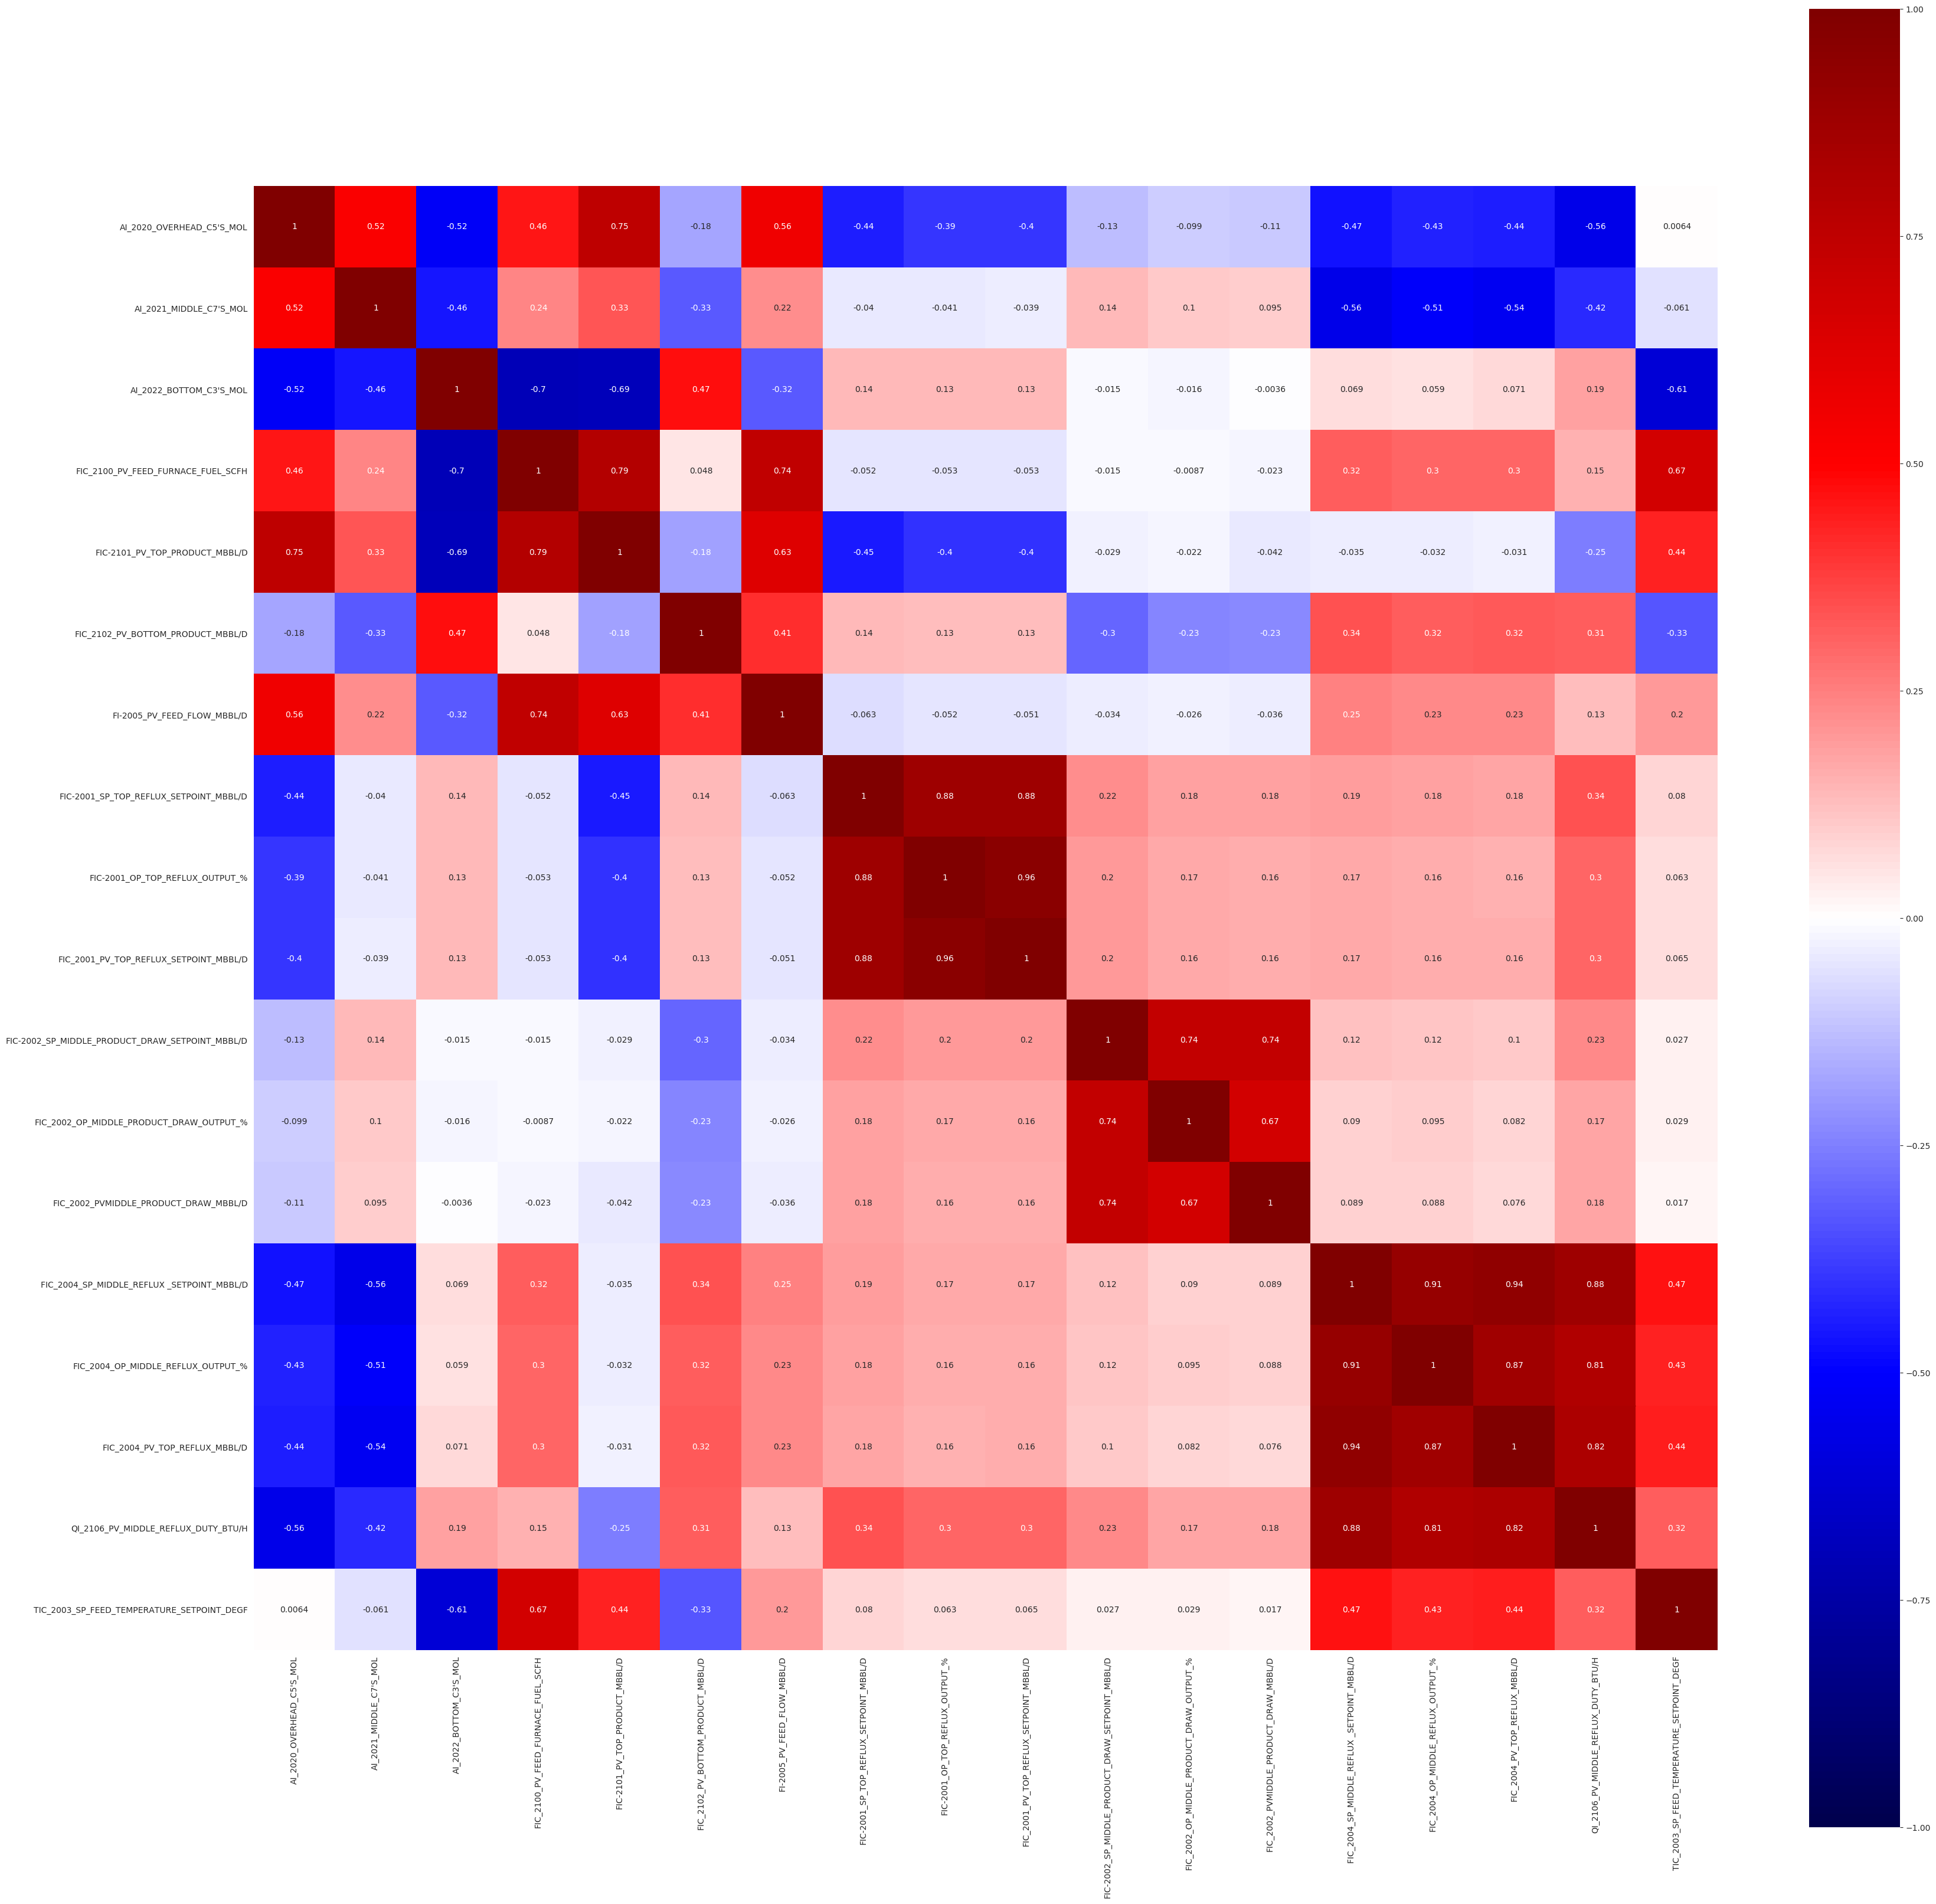

In [67]:
#find the correlation between features
plt.figure(figsize=(40,40))
fig1=sns.heatmap(df.corr(method='spearman'),vmin=-1,vmax=1,cmap= 'seismic',annot=True,square=True)
fig1.figure.savefig('heat map correlation.png')
plt.show()

In [55]:
df_response=df[response_variables]

In [60]:
df_AI1=df["AI_2020_OVERHEAD_C5'S_MOL"]
df_AI_top=pd.concat([df_AI1,df_response],axis=1)

In [61]:
df_AI2=df["AI_2021_MIDDLE_C7'S_MOL"]
df_AI_middle=pd.concat([df_AI2,df_response],axis=1)

In [62]:
df_AI3=df["AI_2022_BOTTOM_C3'S_MOL"]
df_AI_bottom=pd.concat([df_AI3,df_response],axis=1)

In [50]:
df_AI_top.head()

   AI_2020_OVERHEAD_C5'S_MOL  FIC_2100_PV_FEED_FURNACE_FUEL_SCFH  \
0                    2.00000                             8.50000   
1                    2.00360                             8.50735   
2                    2.00870                             8.50977   
3                    2.00385                             8.50838   
4                    1.99852                             8.50365   

   FIC-2101_PV_TOP_PRODUCT_MBBL/D  FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D  \
0                         2.10000                            1.70000   
1                         2.09686                            1.71730   
2                         2.09280                            1.72500   
3                         2.08587                            1.71878   
4                         2.08028                            1.71360   

   FI-2005_PV_FEED_FLOW_MBBL/D  FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D  \
0                      5.02153                                 2.64333   
1         

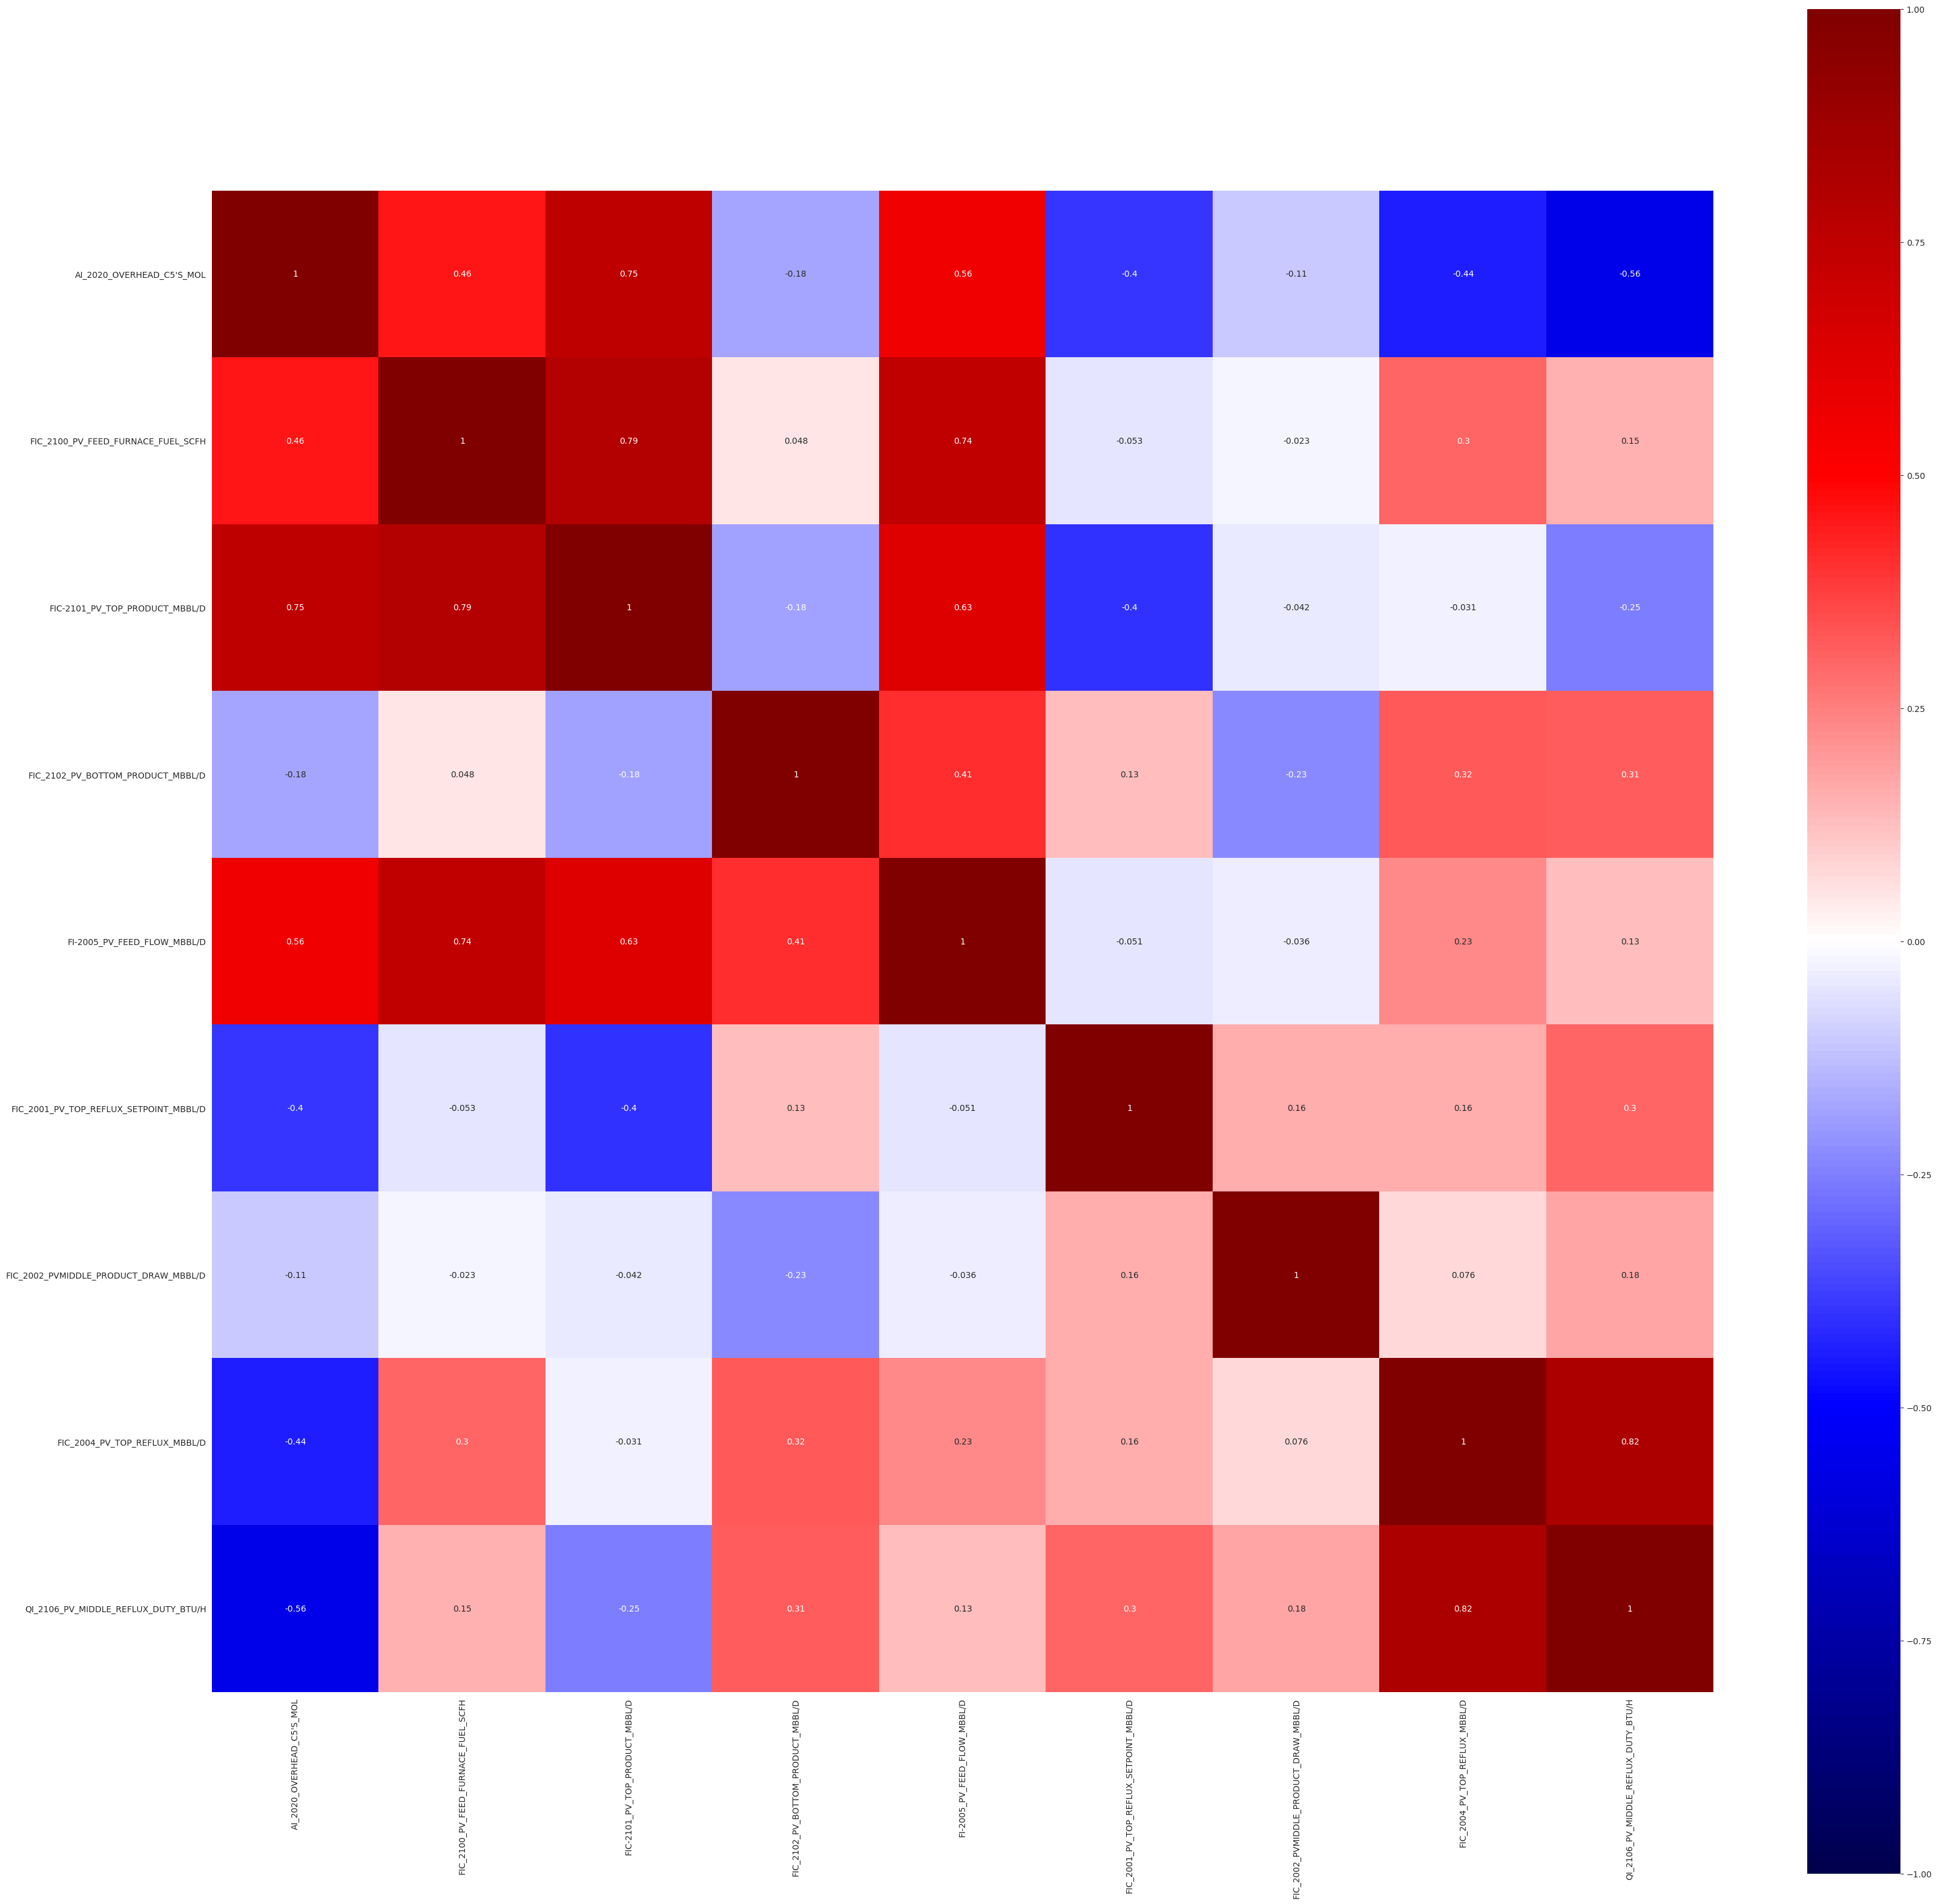

In [51]:
#find the correlation between features
plt.figure(figsize=(40,40))
fig2=sns.heatmap(df_AI_top.corr(method='spearman'),vmin=-1,vmax=1,cmap= 'seismic',annot=True,square=True)
fig2.figure.savefig('heat map correlation AI_top.png')
plt.show()

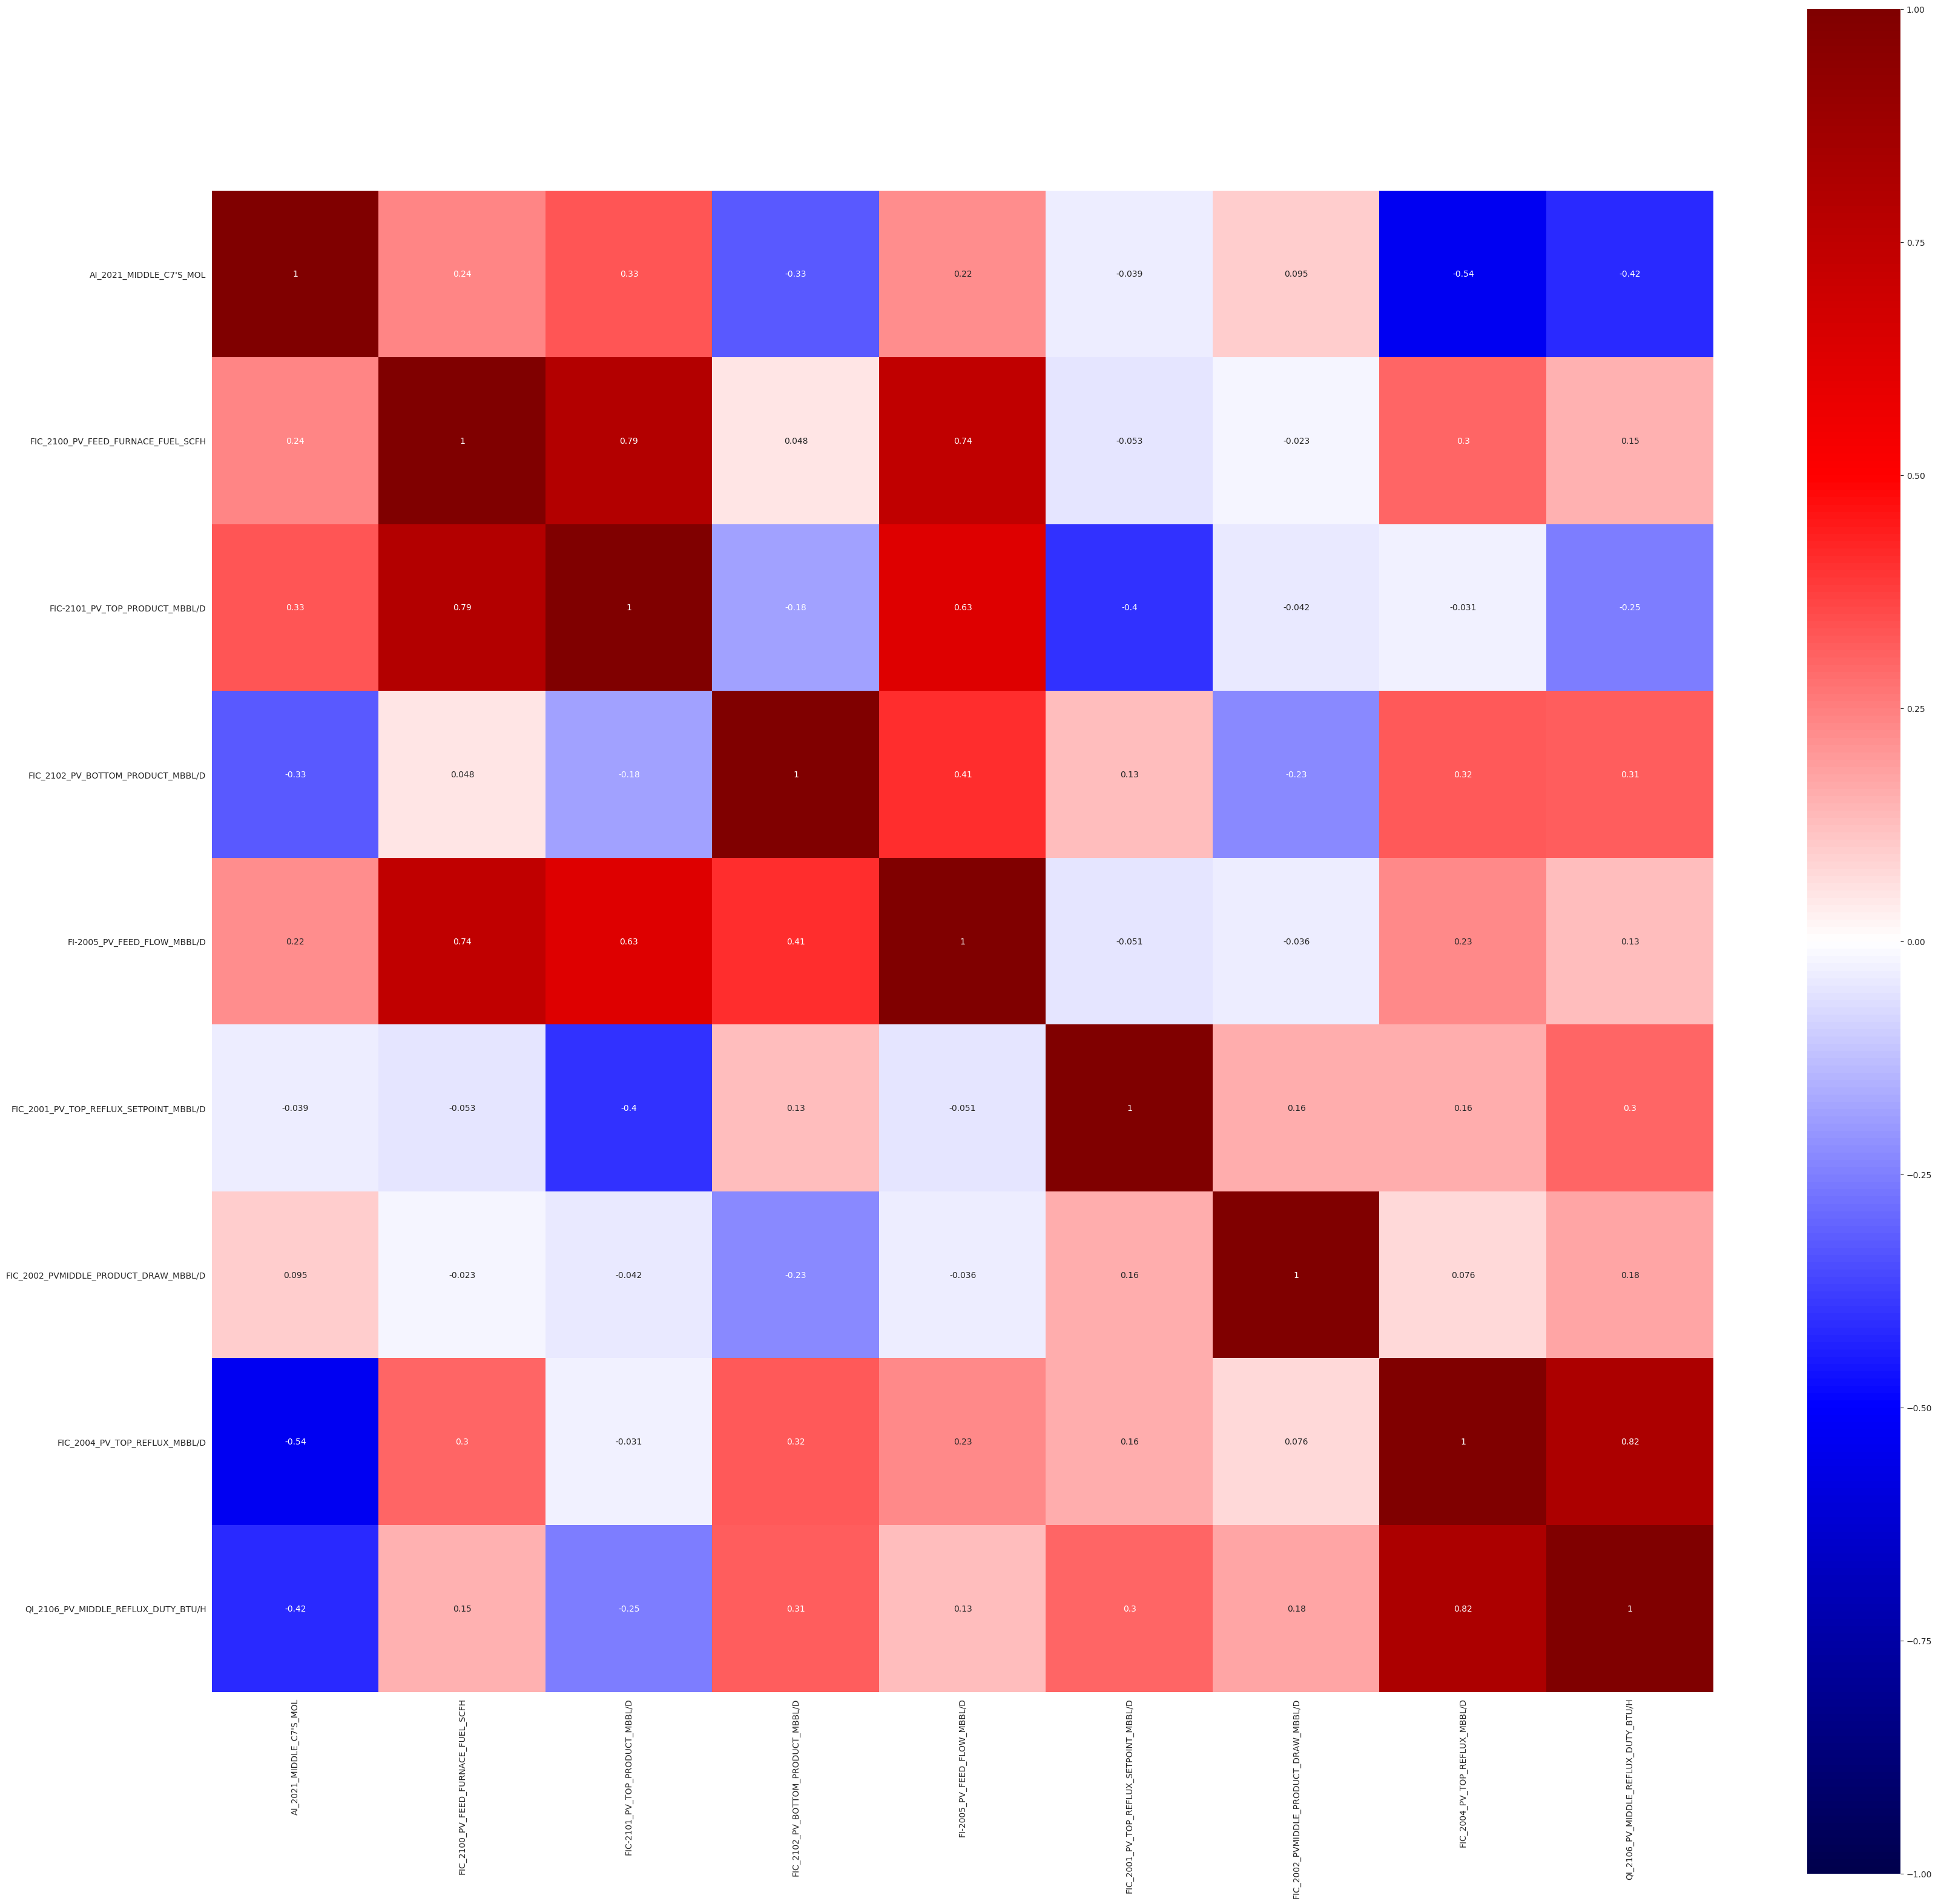

In [63]:
#find the correlation between features
plt.figure(figsize=(40,40))
fig3=sns.heatmap(df_AI_middle.corr(method='spearman'),vmin=-1,vmax=1,cmap= 'seismic',annot=True,square=True)
fig3.figure.savefig('heat map correlation AI_middle.png')
plt.show()

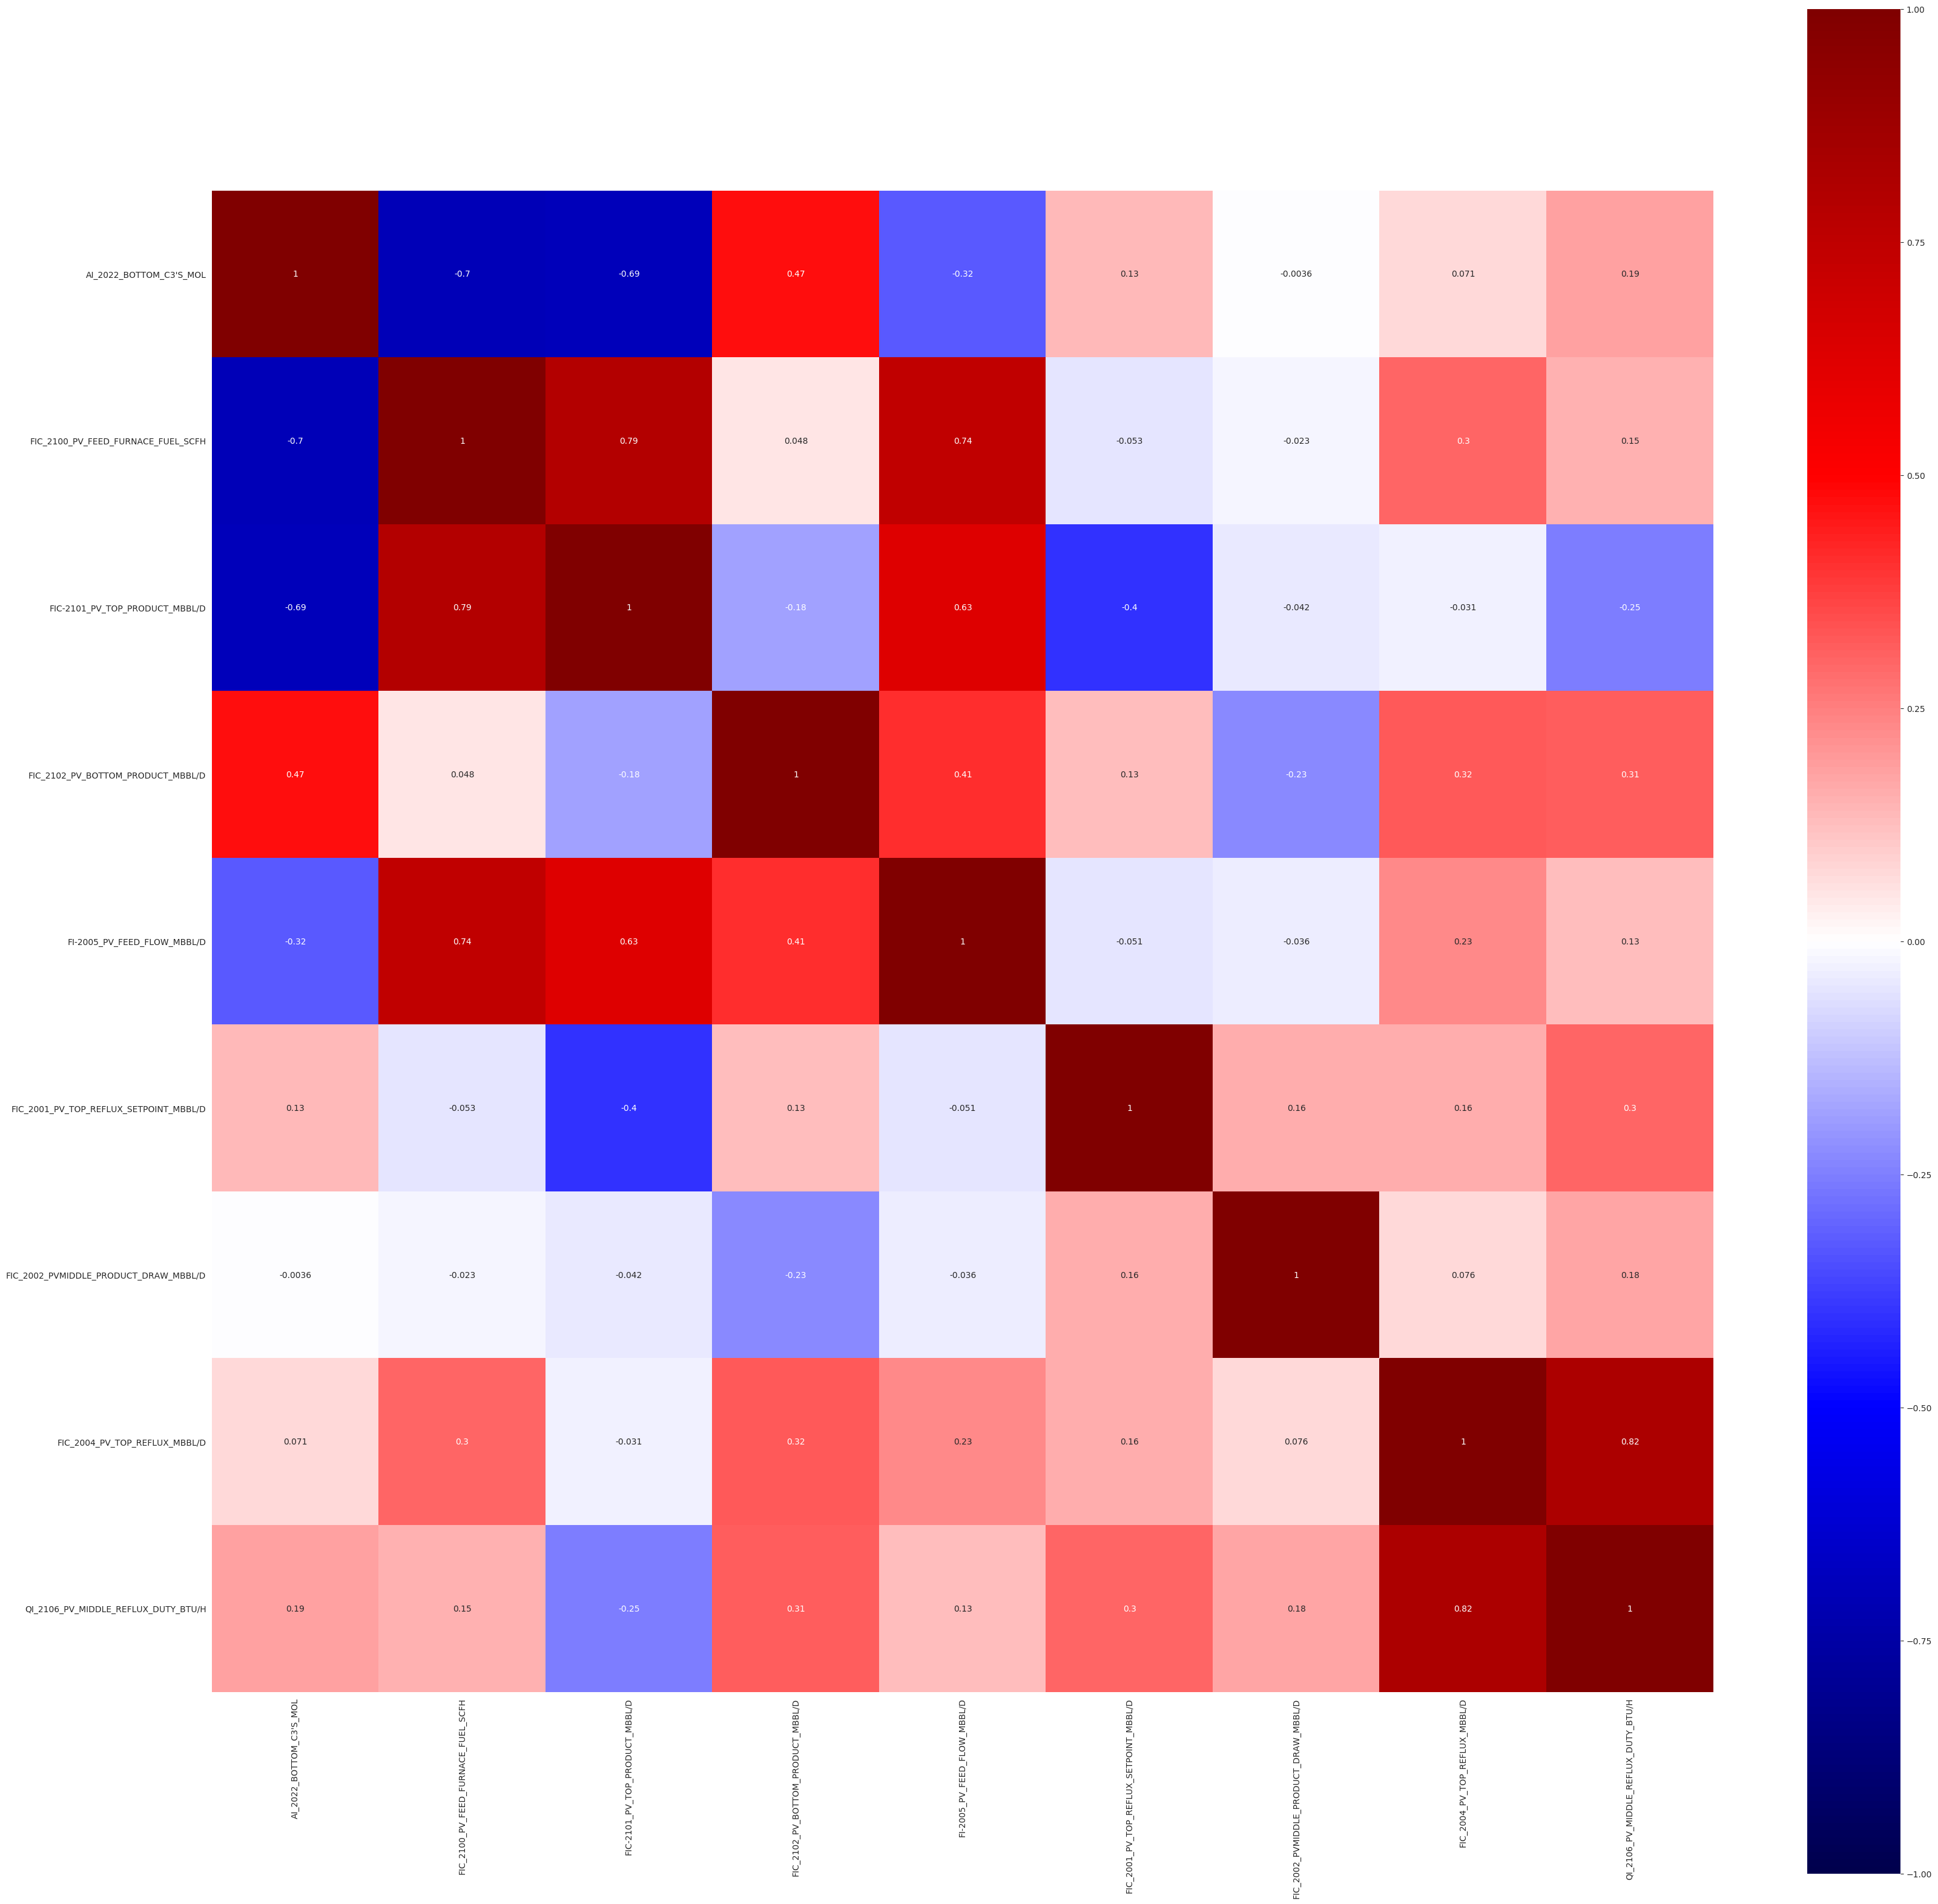

In [68]:
#find the correlation between features
plt.figure(figsize=(40,40))
fig4=sns.heatmap(df_AI_bottom.corr(method='spearman'),vmin=-1,vmax=1,cmap= 'seismic',annot=True,square=True)
fig4.figure.savefig('heat map correlation AI_bottom.png')
plt.show()

In [64]:
corr_AI_top=df_AI_top.corr()
corr_AI_top.to_csv("corr_AI_top.csv")

In [74]:
corr_AI_middle=df_AI_middle.corr()
corr_AI_middle.to_csv("corr_AI_middle.csv")

In [75]:
corr_AI_bottom=df_AI_bottom.corr()
corr_AI_bottom.to_csv("corr_AI_bottom.csv")

In [73]:
for i in response_variables:
    
    print(i)

FIC_2100_PV_FEED_FURNACE_FUEL_SCFH
FIC-2101_PV_TOP_PRODUCT_MBBL/D
FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D
FI-2005_PV_FEED_FLOW_MBBL/D
FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D
FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D
FIC_2004_PV_TOP_REFLUX_MBBL/D
QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H


### Using top and bottom analyzers to predict the values of the process variables (Top product draw flow)

#### Data Preprocessing and visualization ####

In [78]:
# for data dimensionality reduction as deduction of the number of features affecting the traget value.
df_top_product=df[["FIC-2101_PV_TOP_PRODUCT_MBBL/D","AI_2020_OVERHEAD_C5'S_MOL","AI_2022_BOTTOM_C3'S_MOL"]]

In [79]:
df_top_product.rename(columns={"FIC-2101_PV_TOP_PRODUCT_MBBL/D":"Top_product","AI_2020_OVERHEAD_C5'S_MOL":"AI_top",
                               "AI_2022_BOTTOM_C3'S_MOL": "AI_bottom"}, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [80]:
df_top_product.head()

   Top_product   AI_top  AI_bottom
0      2.10000  2.00000    4.00000
1      2.09686  2.00360    3.99831
2      2.09280  2.00870    3.97746
3      2.08587  2.00385    3.97262
4      2.08028  1.99852    3.98841

In [81]:
df_top_product.isnull().sum()

Top_product    0
AI_top         0
AI_bottom      0
dtype: int64

In [82]:
df_top_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5723 entries, 0 to 5819
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Top_product  5723 non-null   float64
 1   AI_top       5723 non-null   float64
 2   AI_bottom    5723 non-null   float64
dtypes: float64(3)
memory usage: 178.8 KB


In [84]:
discribe_data=df_top_product.describe()

In [85]:
discribe_data.to_csv("discribe_data.csv")

In [87]:
data_corr_top_product=df_top_product.corr(method='spearman')

In [88]:
data_corr_top_product.to_csv("data_corr_top_product.csv")

In [89]:
df_top_product.to_csv("df_top_product.csv")

##### DATA VISUALIZATION

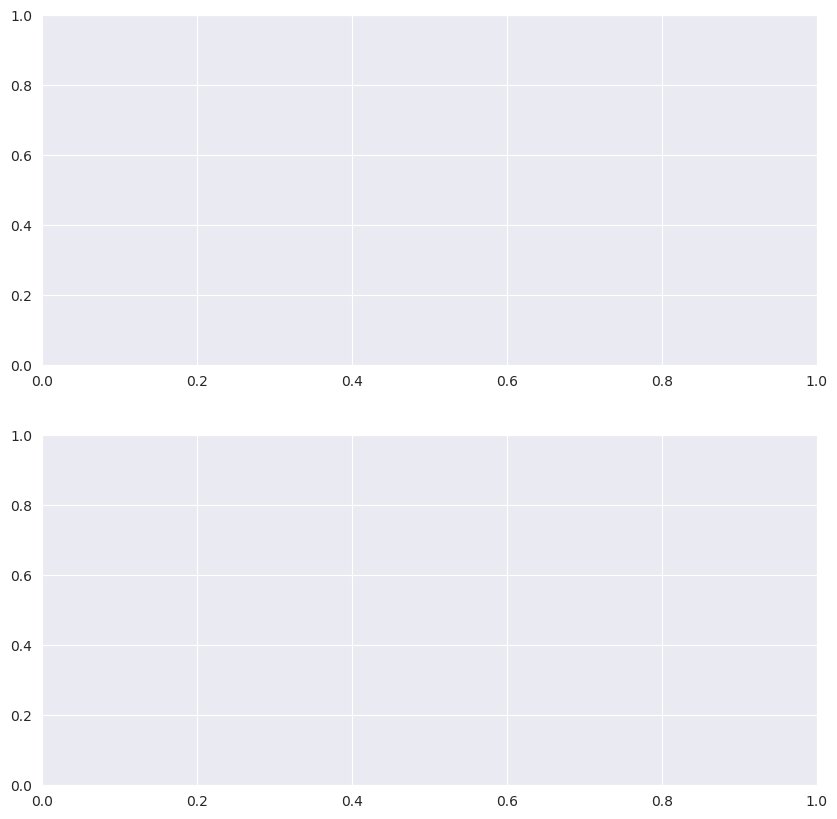

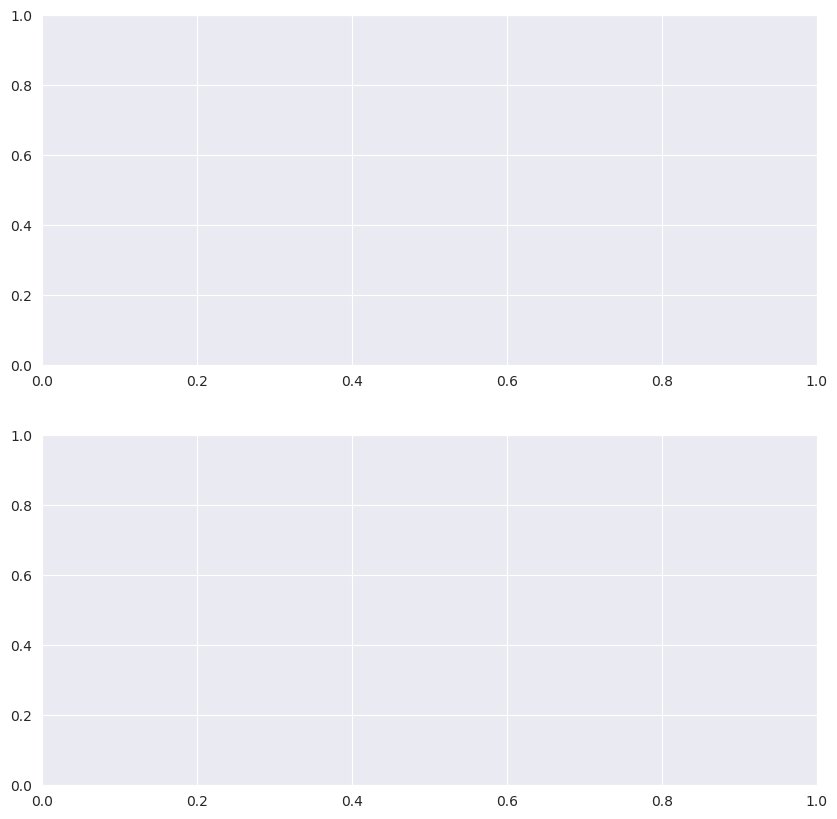

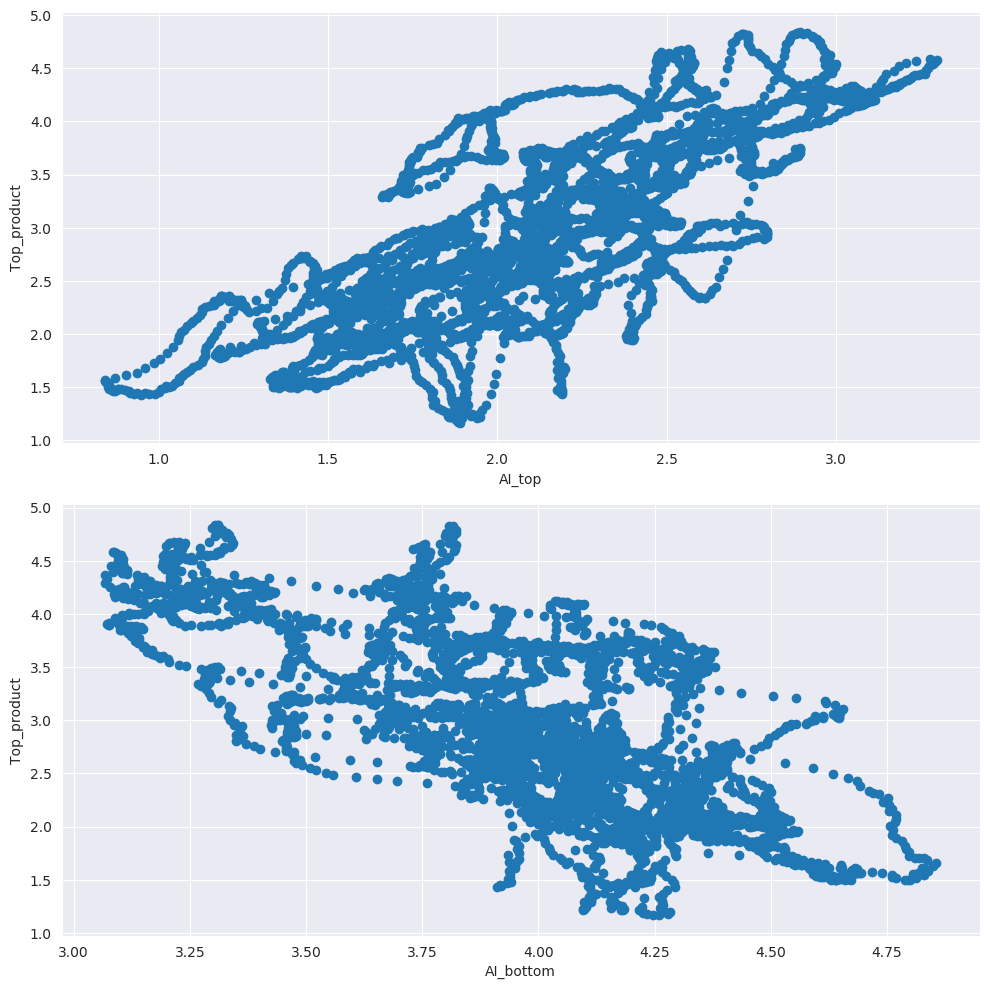

In [102]:
# Create subplots for each column pair
df_top_product_features=df_top_product[["AI_top","AI_bottom"]]
fig, axs = plt.subplots(2,1, figsize=(10, 10))
axs = axs.flatten()
for i, col in enumerate(df_top_product_features.columns):
    axs[i].scatter(df_top_product_features[col], df_top_product["Top_product"])
    axs[i].set_xlabel(col)
    axs[i].set_ylabel("Top_product")

plt.tight_layout()
plt.show()

#### Splitting the data into train and test